# Imports\


TODO:
1) check value/vat/no vat
2) check headlines, fix it


In [7]:
# !export GPN_DB_HOST=192.168.10.36


In [8]:
#!ls -la ../../work
# #!mv ../../../documents.json.zip ../../work
# # !unzip '../../work/documents.json.zip' '../../work/documents.json'
# !mv documents.json ../../work

In [9]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [10]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')



2023-02-16 09:56:36.265417: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
DEBUG - 2023-02-16 09:56:38,469 - retrain_ipynb - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [11]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import analyser.hyperparams 

Nemoware Analyser v23.2.7
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [12]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding

from analyser.structures import DocumentState

from pathlib import Path
from bson import ObjectId

from datetime import date
from dateutil.relativedelta import relativedelta


from pymongo import ASCENDING

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None
[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [5]:
import mlflow
mlflow.start_run(run_name='fetch trainset from db')
                 
# experiment_id = mlflow.create_experiment(
#     "Fetching training set from DB",
# #     tags={"version": "v1", "priority": "P1"},
# )                 
# experiment_id

<ActiveRun: >

### Prepare workdir

In [13]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work


### Query DB for contact IDs

#### Load meta data CSV

In [14]:
!touch /root/artem/work/contract_trainset_meta.temp.csv

In [15]:
# stats[["user_correction_date", 'analyze_date']].max().max()

In [16]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    mlflow.log_metric('last_doc_date', lastdate)
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(f'lastdate={lastdate} ; export_fn={export_fn}')
stats['source'] = 'db'
stats

ERROR - 2023-02-16 09:56:43,298 - retrain_ipynb - float() argument must be a string or a number, not 'Timestamp'
Traceback (most recent call last):
  File "/tmp/ipykernel_3929596/1875502965.py", line 16, in <module>
    mlflow.log_metric('last_doc_date', lastdate)
  File "/root/artem/env/lib/python3.8/site-packages/mlflow/tracking/fluent.py", line 643, in log_metric
    MlflowClient().log_metric(run_id, key, value, get_current_time_millis(), step or 0)
  File "/root/artem/env/lib/python3.8/site-packages/mlflow/tracking/client.py", line 687, in log_metric
    self._tracking_client.log_metric(run_id, key, value, timestamp, step)
  File "/root/artem/env/lib/python3.8/site-packages/mlflow/tracking/_tracking_service/client.py", line 284, in log_metric
    metric_value = convert_metric_value_to_float_if_possible(value)
  File "/root/artem/env/lib/python3.8/site-packages/mlflow/tracking/metric_value_conversion_utils.py", line 52, in convert_metric_value_to_float_if_possible
    return float(x

ERROR: cannot load /root/artem/work/contract_trainset_meta.temp.csv
lastdate=1900-01-01 00:00:00 ; export_fn=/root/artem/work/contract_trainset_meta.temp.csv


,source


# functions

In [11]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  n_headers = len(d.analysis.get('headers', []))
  stats.at[_id, 'headers'] = n_headers
    
  _value_tag = attr_tree.get('price')
  
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    

  span = attr_tree.get('subject', {}).get('span',[0,0])
  subject_len = span[1] - span[0]
  stats.at[_id, 'subj_len'] = subject_len  

  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)
    

    # find_in_dict('attributes_tree.creation_date', d.user)

  valid_state = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state)
  if not valid_state:
    print(_id, 'invalid state: ', d.state)
  valid_struct = ('contract' in jd.analysis['attributes_tree'])
  if not valid_struct:
    print(_id, 'invalid structure: ', d.state)
  stats.at[_id, 'valid'] = valid_state and valid_struct and subject_len>0 and subject_len<=300 and n_headers>0


  


d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
jd = DbJsonDoc(d)
add_stats_record(jd, stats)
stats.loc['5fe34f62b770574a005553be']

DB HOST IS: 192.168.10.36


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

source                                                db
checksum                da2dd54cdcc5b4480207c9def7741d14
version                                           2.3.13
export_date                   2023-02-15 19:40:32.932988
len                                                  759
analyze_date            2020-12-23 17:14:16.727000+00:00
value                                           1.64e+06
value_log1p                                      14.3102
value_span                                           128
currency                                             RUB
org-1-name                        Газпромнефть-Снабжение
org-1-alias                               Благотворитель
org-2-name                           инициатив «Эпсилон»
org-2-alias                              Благополучатель
subject                                          Charity
subject confidence                                     1
user_correction_date    2022-12-08 19:07:01.522000+00:00
valid                          

# load old json

In [12]:
import json
import re
from bson import json_util

_DEBUG = False
file_data=None

try:
    fn = work_dir / 'documents.json'
    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)

        print(f'total docs in {fn} is {len(file_data)}')    
        _DEBUG = True
except Exception as ex:
    logger.exception(ex)    




if _DEBUG:
    a_doc_from_json=DbJsonDoc(file_data[3])

    print(a_doc_from_json.get_attributes_tree())
    print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622
{'orgs': [{'type': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.49801500000000004, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [56, 57], 'span_map': 'words', 'confidence': 0.972, 'value': 'Арендатор'}}, {'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.505665, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9905, 'value': 'ЭКРУСС'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Арендодатель'}}], 'date': {'span': [9, 14], 'span_map': 'words', 'confidence': 1, 'value': datetime.datetime(2016, 5, 10, 0, 0, tzinfo=<bson.tz_util.FixedOffset object at 0x7f508cb86460>)}, 'number': {'span': [1, 4], 'span_map': 'words', 'confidence': 1, 'value': 'RP 16-06'}, 'subject': {'span': [100, 1

semantic_map_keys_contract ['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']


fixed number: ['№ RP 16-06'] -->  ['RP 16-06']


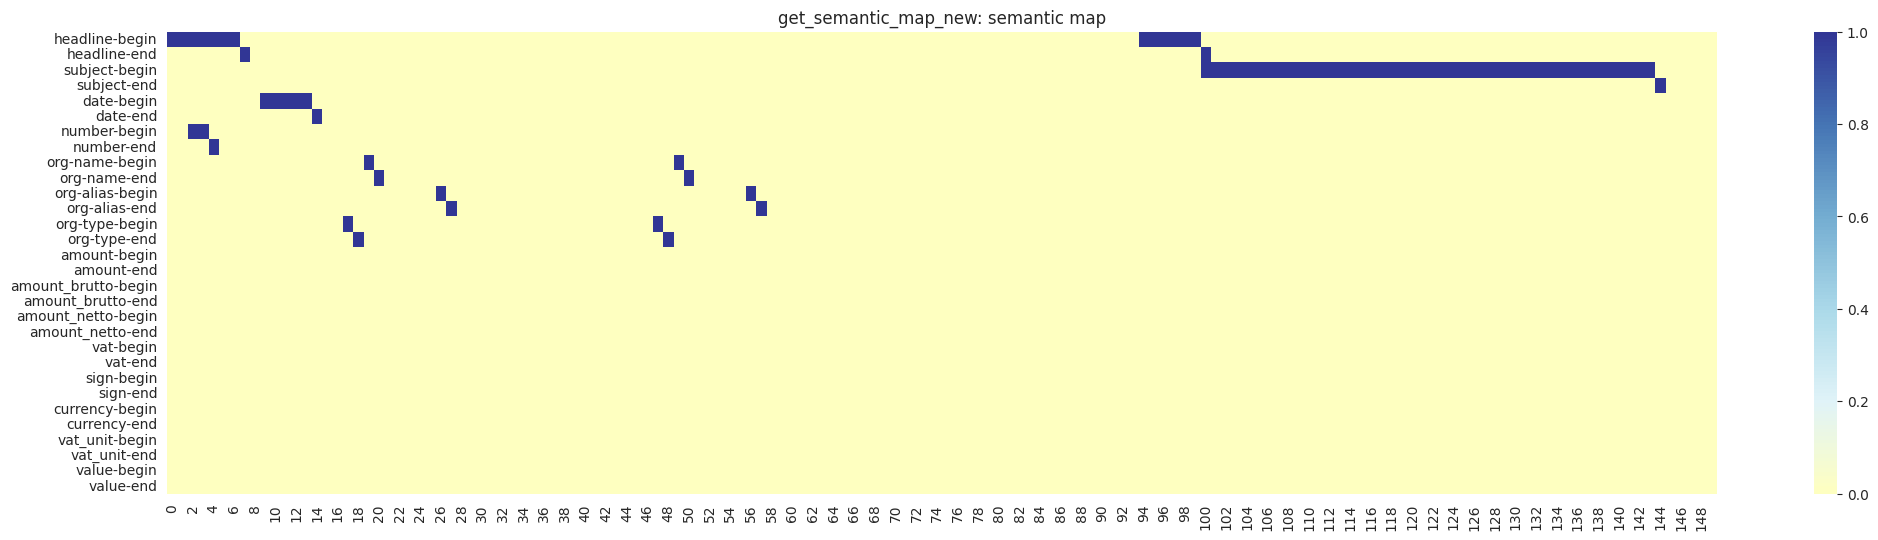

1.0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3148    0.0
3149    0.0
3150    0.0
3151    0.0
3152    0.0
Name: date-begin, Length: 3153, dtype: float64


In [13]:

# TODO: import!!!

from tf_support.super_contract_model import get_semantic_map_new, \
        semantic_map_keys_contract, t_semantic_map_keys_common, t_semantic_map_keys_org, t_semantic_map_keys_price

# print("semantic_map_keys", semantic_map_keys[8:14])
# print("semantic_map_keys", semantic_map_keys[4:7])
# print("semantic_map_keys all", semantic_map_keys)
print("semantic_map_keys_contract", semantic_map_keys_contract)

print()
print()




del get_semantic_map_new


def fix_contract_number_span(span:[], textmap)  :
  if span is not None:
    span = [span[0], span[1]] #//typesafety
    for i in range(span[0], span[1]):
      t = textmap[i]
      t = t.strip('_')
      t = t.strip().lstrip('№').lstrip().lstrip(':').lstrip('N ').lstrip().rstrip('.')
      if t == '':
        span[0] = i + 1
    for i in range(span[1], span[0]):
      t = textmap[i]
      t = t.strip('_')
      t = t.strip().lstrip('№').lstrip().lstrip(':').lstrip('N ').lstrip().rstrip('.')
      if t == '':
        span[1] = i - 1
    
#     if span[1]-span[0] == 0:
#       return None

  return span

def get_semantic_map_new(doc) -> DataFrame:
  _len = len(doc)
  df = DataFrame()

  #init datatable with zeros
  for sl in semantic_map_keys_contract:
    df[sl] = np.zeros(_len)

  attr_tree = doc.get_attributes_tree()

  def add_span_vectors(_name, span): 
    bn = _name + "-begin"
    en = _name + "-end"
    if not span is None:
      df[bn][span[0]:span[1]] = 1.
      df[en][span[1]] = 1.

  # Headers
  headers = doc.analysis['headers']
  for h in headers:
    add_span_vectors('headline', h['span'])

  for n in t_semantic_map_keys_common[1:]:  # 1: == skip headers
    span = attr_tree.get(n, {}).get('span')
    if n=='number':
#         print(f'number: {[doc.get_tokens_map_unchaged().text_range(span)]}')
        span1 = fix_contract_number_span(span, doc.get_tokens_map_unchaged() )
        if span!=span1:
            print(f'fixed number: {[doc.get_tokens_map_unchaged().text_range(span)]} -->  {[doc.get_tokens_map_unchaged().text_range(span1)]}')
        span=span1
    if span:
        add_span_vectors(n, span)

  # Orgs:
  for org in attr_tree.get('orgs', []):  # org number (index)
    for org_part_key in t_semantic_map_keys_org:
#       _nm = 'unknown'
#       try:

      org_part = org.get(org_part_key.replace('org-', ''), {})
      if org_part:
        span = org_part.get('span', None)
        add_span_vectors(org_part_key, span)
#       except Exception as e:
#         logger.exception(e)
#         print('ERROR (sp)', e, org_part_key, _nm)

  _value_tag = attr_tree.get('price', {})
  

  if _value_tag is not None:
    add_span_vectors("value", _value_tag.get('span'))
    amount = get_amount(attr_tree)
    if amount:
      add_span_vectors('amount', amount.get('span'))
    
#     print('_value_tag=', _value_tag)
#     print('amount=', amount)
    for n in t_semantic_map_keys_price:
      _value_tag_part = _value_tag.get(n)
#       print('n=', n)
#       print('_value_tag_part=', _value_tag_part)
      if _value_tag_part:
        add_span_vectors(n, _value_tag_part.get('span'))

  return df[semantic_map_keys_contract]


if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:150], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

In [14]:
# semantic_map_keys[4:7]

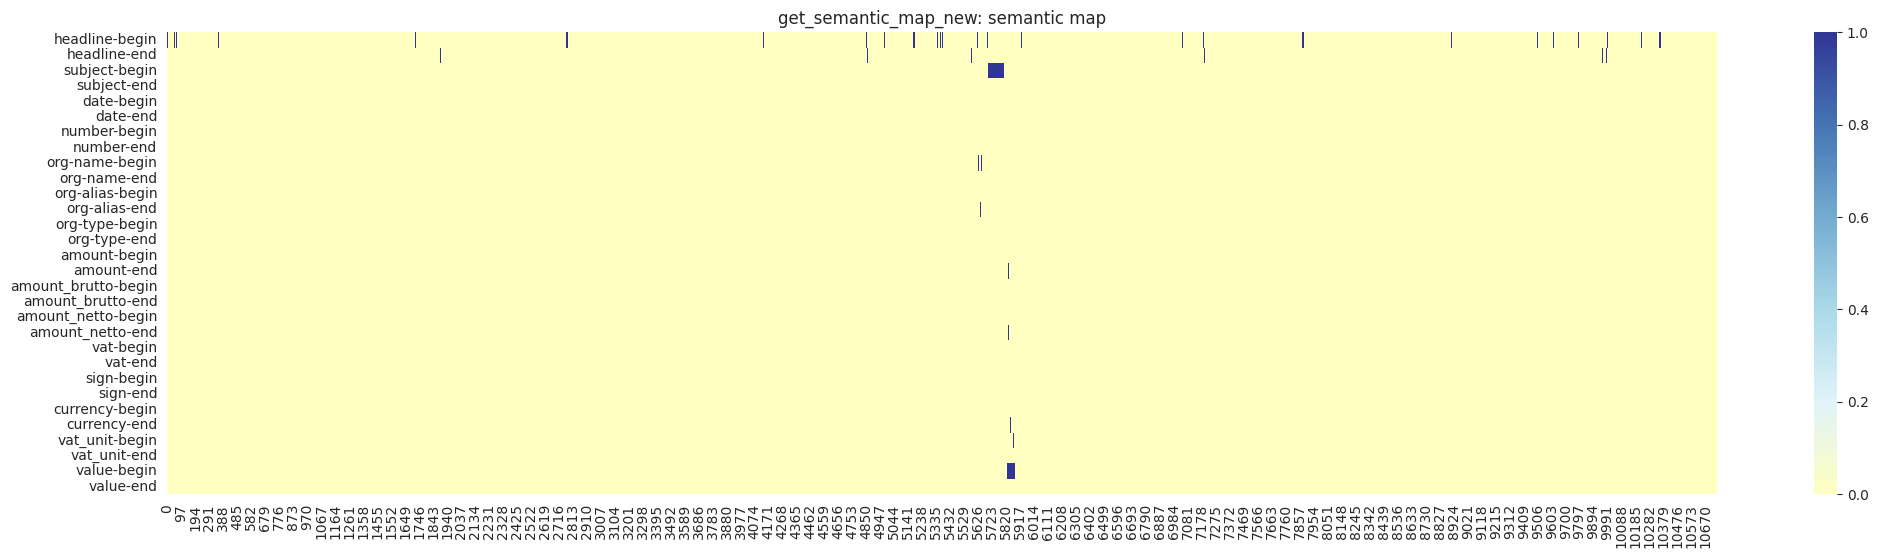

In [15]:
#test one

d = get_doc_by_id(ObjectId('636dfd1473925c8dae26f910'))
if d is not None:
    jd = DbJsonDoc(d)
    semantic_map: DataFrame = get_semantic_map_new(jd)


    plot_embedding(semantic_map, f'get_semantic_map_new: semantic map')

### Adding data from old json file to the stats table

In [16]:
# fff
files_dict = {}

if file_data:
    k=0
    for d in file_data:
        k+=1 
        jd = DbJsonDoc(d)
    #     print( jd.analysis['analyze_timestamp'])
        files_dict[jd.get_id()] = jd
        try:            
            add_stats_record(jd, stats, source = 'file')
        except Exception as e:
            print(e)
            print(jd.get_id())
#             raise (e)

        if k % 100 == 0:
#             stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=False)
#             stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=False)
#             stats['export_date'] = pd.to_datetime(stats['export_date'], utc=False)
            
    
            print(f'{k} of {len(file_data)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')

            
            
stats.to_csv(export_fn, index=True)
stats.to_csv('tmp.csv', index=True)

print(f'stats saved to {export_fn}')

# del file_data
stats




100 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv

5efdb73b777d4b67a92d533c
500 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
600 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,SUN,SUN,Service,1.000000,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2.970000e+03,7.996654,1364.0,RUB,...,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,9.000000e+04,11.407576,1834.0,RUB,...,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,NaN
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Газпромнефть-Снабжение,Агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,1.548241e+07,16.555215,699.0,RUB,...,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63a4306dbeaa9eeec65ecafe,db,3bc04887446d02692e886db2545bba61,23.2.7,2023-02-14 15:40:04.968835,13410.0,2023-02-07 17:27:25.210000+00:00,0.000000e+00,0.000000,2572.0,RUB,...,NaN,Принципал,BankGuarantees,0.999653,NaT,False,AGREEMENT,0.0,21.0,NaN
63c506cde2456d59975e12e6,db,d4c224c746af80e3b26d17563acc0112,23.2.7,2023-02-14 15:40:09.839703,581.0,2023-02-07 17:28:16.977000+00:00,1.200000e+01,2.564949,251.0,RUB,...,Рога и копыта,Исполнитель,Other,0.661803,NaT,False,CONTRACT,0.0,1.0,NaN
63c506c7e2456d59975e1223,db,aec511aa010b6684d2db1700ad6fc426,23.2.7,2023-02-14 15:40:13.836320,19510.0,2023-02-07 17:29:06.679000+00:00,3.875564e+04,10.565057,4260.0,RUB,...,NaN,ИСПОЛНИТЕЛЬ,Service,0.999310,NaT,False,CONTRACT,0.0,29.0,NaN
5fbbbd13a2b4551c061078bf,db,d4df449c532614c3046170f1e66c8e5a,23.01.23,2023-02-14 15:40:15.375182,586.0,2023-02-08 14:56:22.731000+00:00,3.075000e+08,19.543986,282.0,RUB,...,Страховое общество газовой промышленности,Страховщик,NaN,NaN,2023-02-08 12:00:08.079000+00:00,False,SUPPLEMENTARY_AGREEMENT,0.0,5.0,NaN


In [17]:
# stats = stats.drop('63c506afe2456d59975e0fcd')
stats[stats.index.duplicated()]



,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos


In [18]:
invalid = stats[stats['valid']==False]
print(f'{len(invalid)}: number of invalid records')
invalid

106: number of invalid records


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos
629a06b3d3b1c36092555a6b,db,af69993eeb005bd8ab04bea1c3276414,3.0.0,2023-01-31 18:20:56.263976,166.0,2022-06-03 16:04:04.260000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,Other,0.967818,NaT,False,ANNEX,0.0,1.0,0.0
62a99d94326a4191e5f17386,db,436b7959cf4ea33ed4ee69d446728b68,3.0.0,2023-01-31 18:20:56.660476,430.0,2022-06-15 11:57:41.999000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,Other,0.978722,NaT,False,ANNEX,0.0,5.0,0.0
62bdad2b6e75fae95cce25d2,db,e8af42c518bbc8fe62ba7ccadcd94516,3.0.0,2023-01-31 18:20:57.980333,354.0,2022-06-30 17:04:23.583000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,Other,0.922993,NaT,False,ANNEX,0.0,3.0,0.0
62c54858e599c73b751b7955,db,025221e00f999c9122213411f238e253,3.0.0,2023-01-31 18:20:58.162243,239.0,2022-07-06 11:34:00.949000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,Other,0.955254,NaT,False,ANNEX,0.0,7.0,0.0
62c54d98e599c73b751b7a6e,db,2d353ef8a5f3e26e6232b3639f8f318f,3.0.0,2023-01-31 18:20:58.459993,21.0,2022-07-06 11:55:32.514000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,Other,0.976310,NaT,False,ANNEX,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63a4306dbeaa9eeec65ecafe,db,3bc04887446d02692e886db2545bba61,23.2.7,2023-02-14 15:40:04.968835,13410.0,2023-02-07 17:27:25.210000+00:00,0.000000e+00,0.000000,2572.0,RUB,...,NaN,Принципал,BankGuarantees,0.999653,NaT,False,AGREEMENT,0.0,21.0,NaN
63c506cde2456d59975e12e6,db,d4c224c746af80e3b26d17563acc0112,23.2.7,2023-02-14 15:40:09.839703,581.0,2023-02-07 17:28:16.977000+00:00,1.200000e+01,2.564949,251.0,RUB,...,Рога и копыта,Исполнитель,Other,0.661803,NaT,False,CONTRACT,0.0,1.0,NaN
63c506c7e2456d59975e1223,db,aec511aa010b6684d2db1700ad6fc426,23.2.7,2023-02-14 15:40:13.836320,19510.0,2023-02-07 17:29:06.679000+00:00,3.875564e+04,10.565057,4260.0,RUB,...,NaN,ИСПОЛНИТЕЛЬ,Service,0.999310,NaT,False,CONTRACT,0.0,29.0,NaN
5fbbbd13a2b4551c061078bf,db,d4df449c532614c3046170f1e66c8e5a,23.01.23,2023-02-14 15:40:15.375182,586.0,2023-02-08 14:56:22.731000+00:00,3.075000e+08,19.543986,282.0,RUB,...,Страховое общество газовой промышленности,Страховщик,NaN,NaN,2023-02-08 12:00:08.079000+00:00,False,SUPPLEMENTARY_AGREEMENT,0.0,5.0,NaN


In [19]:
# !tail /root/artem/work/contract_trainset_meta.temp.csv

# Fetch fresh docs from Mongo DB

In [20]:


# if True:
lastdate = lastdate + relativedelta(days=-5)
#     lastdate = datetime.combine(lastdate, datetime.min.time())

lastdate = pd.to_datetime( lastdate , utc=True)
lastdate

Timestamp('2023-02-09 09:33:18.317000+0000', tz='UTC')

In [21]:
yesterday = datetime.now() + relativedelta(days=-1)  
# {'analysis.analyze_timestamp': {'$gt': yesterday}},



query = {'user.updateDate': {'$gt': yesterday}}
db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
                               ).limit(5000)

_r = list([i for i in res])
# print(res[0])
_s = f"#### Всего размечено документов после {yesterday} : {len(_r)}"
display(Markdown(_s))
yseterday_ids=[i["_id"] for i in _r]


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего размечено документов после 2023-02-14 19:41:01.029321 : 7

In [22]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}}, 
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

#### Всего новых документов после 2023-02-09 09:33:18.317000+00:00 : 30

[{'_id': ObjectId('5e6101650cf5aa0cfe37d10b'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 15,
  'user': {'updateDate': datetime.datetime(2023, 2, 11, 21, 7, 39, 872000)}},
 {'_id': ObjectId('5ec2b8da665f7603e03b1265'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 2, 11, 7, 19, 41, 320000)}},
 {'_id': ObjectId('5ec2b8da665f7603e03b127a'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 2, 11, 20, 29, 12, 536000)}},
 {'_id': ObjectId('5ebd312d665f7603e03b11d2'),
  'user': {'updateDate': datetime.datetime(2023, 2, 10, 19, 19, 22, 176000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}}]

# Prepare training set

In [23]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(len(new_docs_ids))
# sample_id = ObjectId('637f7bf0e712cc2ff2e943d3')

# sample_id = docs_ids[1]
# sample_id
# d = get_doc_by_id(sample_id)

# jd = DbJsonDoc(d)
# jd.get_id()
# print(d['_id'])


#==========================Test 1 doc
    
# print(jd.get_version_string())
 
# add_stats_record(jd, stats)
# stats.loc[str(jd._id)]
 

30


In [24]:
# plot_embedding(get_semantic_map_new(jd)[:300], f'semantic map')
# print(len(docs_ids))

In [25]:
def add_to_stats_list(docs_ids):
    for k, oid in enumerate(docs_ids):
        d = get_doc_by_id(ObjectId(str(oid)))
        try:
            jd = DbJsonDoc(d)
            add_stats_record(jd, stats)
        except Exception as e:
            print(oid)
            print (e)

        if k % 100 == 0:
            print(f'{k} of {len(docs_ids)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')
        
add_to_stats_list(docs_ids)        
stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
stats

0 of 30
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,SUN,SUN,Service,1.000000,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2.970000e+03,7.996654,1364.0,RUB,...,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,9.000000e+04,11.407576,1834.0,RUB,...,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,NaN
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Газпромнефть-Снабжение,Агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,1.548241e+07,16.555215,699.0,RUB,...,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c506cde2456d59975e12e6,db,d4c224c746af80e3b26d17563acc0112,23.2.7,2023-02-14 15:40:09.839703,581.0,2023-02-07 17:28:16.977000+00:00,1.200000e+01,2.564949,251.0,RUB,...,Рога и копыта,Исполнитель,Other,0.661803,NaT,False,CONTRACT,0.0,1.0,NaN
63c506c7e2456d59975e1223,db,aec511aa010b6684d2db1700ad6fc426,23.2.7,2023-02-14 15:40:13.836320,19510.0,2023-02-07 17:29:06.679000+00:00,3.875564e+04,10.565057,4260.0,RUB,...,NaN,ИСПОЛНИТЕЛЬ,Service,0.999310,NaT,False,CONTRACT,0.0,29.0,NaN
5fbbbd13a2b4551c061078bf,db,d4df449c532614c3046170f1e66c8e5a,23.01.23,2023-02-14 15:40:15.375182,586.0,2023-02-08 14:56:22.731000+00:00,3.075000e+08,19.543986,282.0,RUB,...,Страховое общество газовой промышленности,Страховщик,NaN,NaN,2023-02-08 12:00:08.079000+00:00,False,SUPPLEMENTARY_AGREEMENT,0.0,5.0,NaN
5fb674fa33c72547b754ffa2,db,d4df449c532614c3046170f1e66c8e5a,23.01.23,2023-02-15 19:41:01.924201,586.0,2023-02-09 11:18:54.245000+00:00,4.783000e+05,13.077996,305.0,RUB,...,Страховое общество газовой промышленности,Страховщик,None,NaN,2023-02-09 08:21:33.765000+00:00,False,SUPPLEMENTARY_AGREEMENT,0.0,5.0,NaN


In [26]:
# _ids = list(
#     stats[stats['source']=='db']
#     [stats['documentType']=='undefined'][ stats['user_correction_date'].notna()].index)


# add_to_stats_list(_ids)        
# stats.to_csv(export_fn, index=True)

s = stats[ stats['source']=='db'] 
# s = s[s['documentType']=='CONTRACT']
# s = s[s['subj_len'].isna()]
# s = s[s['user_correction_date'].notna()]
# s = s[s['value']>0]
_ids = list(s[s['headers'].isna()].index)
print(len(_ids))
add_to_stats_list(_ids)     
print(f'saving to {export_fn}; {len(stats)} records')
stats.to_csv(export_fn, index=True)

13
637397e2a8eb8dc64b37543b
'NoneType' object is not iterable
0 of 13
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
637397e2a8eb8dc64b37543c
'NoneType' object is not iterable
637397e2a8eb8dc64b37543d
'NoneType' object is not iterable
637397e2a8eb8dc64b37543f
'NoneType' object is not iterable
637397e2a8eb8dc64b375440
'NoneType' object is not iterable
637397e2a8eb8dc64b375441
'NoneType' object is not iterable
637397e2a8eb8dc64b37543a
'NoneType' object is not iterable
637397e2a8eb8dc64b37543e
'NoneType' object is not iterable
637e11d66a07f3e980b2bfbf
'NoneType' object is not iterable
637e11d76a07f3e980b2bfc0
'NoneType' object is not iterable
637f2826fe09513dc6b2bfbf
'NoneType' object is not iterable
637f2826fe09513dc6b2bfc0
'NoneType' object is not iterable
637f725ec15a83c52bb2bfc1
'NoneType' object is not iterable
saving to /root/artem/work/contract_trainset_meta.temp.csv; 6017 records


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


In [27]:
stats = stats[stats.valid!=False]
len(stats)

5910

In [28]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,sun,sun,Service,1.000000,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,иідате. тьско-ііо. тиі рафнческое предприятие ...,поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,"фонд исследований, инноваций, инвестиций тюмен...",арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,NaN
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,газпромнефть-снабжение,агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,газрромнефть-гео,принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c506b9e2456d59975e10b3,db,0c028edaf60667d38b29a12999772a0a,23.2.7,2023-02-14 15:40:15.139403,8266.0,2023-02-07 17:29:23.164000+00:00,142956000.0,18.778047,1033.0,RUB,...,газпромнефть нтц,исполнитель,Service,1.000000,NaT,True,CONTRACT,55.0,40.0,344.0
63c506aee2456d59975e0fc5,db,e1d782e9e5ce6e55863b7f53ced83e51,23.2.7,2023-02-14 15:40:15.191009,2250.0,2023-02-07 17:29:23.999000+00:00,NaN,NaN,NaN,NaN,...,роса,исполнитель,Service,0.955178,NaT,True,CONTRACT,32.0,20.0,182.0
63c506bae2456d59975e10bc,db,6fdd4b665d3fea0ff2e8206a2eee1ccb,23.2.7,2023-02-14 15:40:15.239681,7547.0,2023-02-07 17:29:24.606000+00:00,10000.0,9.210440,5460.0,RUB,...,квартет,поставщик,Deal,1.000000,NaT,True,CONTRACT,29.0,19.0,744.0
628793eb4d1bfe5e5b297dff,db,9cb1a41020a233c28fe3bd4df3071b0e,3.0.0,2023-02-14 15:40:03.394318,1326.0,2022-05-20 16:14:11.196000+00:00,22000.0,9.998843,537.0,NaN,...,ромашка,исполнитель,Service,1.000000,2023-02-08 07:47:19.317000+00:00,True,CONTRACT,92.0,10.0,NaN


In [29]:
stats2['subject'].value_counts()

Service                              2149
Other                                2048
Deal                                  515
Renting                               207
GeneralContract                       204
Loans                                 191
AgencyContract                         97
DealIntellectualProperty               93
Charity                                82
Insurance                              59
RealEstate                             35
ParticipationInOtherOrganizations      26
RealEstateTransactions                 24
PledgeEncumbrance                      20
BankGuarantees                         18
SecuritiesTransactions                 12
BigDeal                                 2
EmployeeContracts                       2
AssetTransactions                       2
Name: subject, dtype: int64

In [30]:
stats2['org-1-alias'].value_counts()

заказчик              1552
исполнитель            631
покупатель             355
поставщик              163
продавец               138
                      ... 
сторона – 1              1
плательщик               1
газпромнефть - 123       1
унисит                   1
благополучатель          1
Name: org-1-alias, Length: 96, dtype: int64

In [31]:
stats2['org-2-alias'].value_counts()

исполнитель      1248
заказчик          667
поставщик         300
покупатель        274
подрядчик         268
                 ... 
исполни гель        1
эмитент             1
весна               1
sun                 1
правительство       1
Name: org-2-alias, Length: 98, dtype: int64

In [32]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head(40)

5910


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,url,unseen,score
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,1.000000,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,0.648909
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-15 19:40:44.884996,1373.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,0.646182,2020-07-18 12:24:26.280000+00:00,True,CONTRACT,106.0,10.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,0.655233
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-15 19:40:41.177191,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,0.000000,2020-06-09 00:40:54.752000+00:00,True,CONTRACT,30.0,5.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,0.759703
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8535.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,1.000000,2023-01-28 01:38:49.198000+00:00,True,CONTRACT,53.0,12.0,100.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.153584
633fd0a69d08c565cfa1232a,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:54.225685,5556.0,2022-10-07 10:10:07.028000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,1.000000,2023-01-27 11:36:12.388000+00:00,True,CONTRACT,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/633f...,False,1.746836
6246a3fa25a983726c7694af,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-15 19:41:01.646095,5556.0,2022-04-01 10:21:21.897000+00:00,1.000000e+11,25.328436,1505.0,None,...,1.000000,2023-02-12 08:47:18.437000+00:00,True,CONTRACT,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6246...,False,1.746836
6285f9c04d1bfe5e5b297ddd,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:53.153480,5556.0,2022-05-19 11:03:36.611000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,1.000000,2023-01-27 11:32:42.657000+00:00,True,CONTRACT,37.0,17.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,False,1.746836
62dfbce15d5a202ba67b842d,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-15 19:41:01.685099,5556.0,2022-07-26 13:08:03.309000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,1.000000,2023-02-11 07:21:05.058000+00:00,True,CONTRACT,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/62df...,False,1.746836
63908ca4a1bded13e629f2eb,db,3bc04887446d02692e886db2545bba61,22.12.7,2023-01-31 18:38:08.500901,13410.0,2022-12-08 13:59:29.898000+00:00,2.000000e+10,23.718998,2572.0,RUB,...,1.000000,2022-12-08 11:04:21.263000+00:00,True,AGREEMENT,84.0,21.0,2222.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,1.805167
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-02-15 19:41:01.882512,4892.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,None,...,1.000000,2023-02-11 20:09:39.660000+00:00,True,CONTRACT,121.0,11.0,148.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,1.971416


In [33]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [34]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,url,unseen,score
5fc7a047c54bc33809e26372,db,82137d4b0ded9b81b1d12f4d9e98c383,2.0.5,2023-01-31 18:21:21.813526,49340.0,2020-12-03 08:07:48.699000+00:00,90619807.0,18.322183,4503.0,RUB,...,0.896091,NaT,True,CONTRACT,44.0,53.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,True,3.692731e+03
5fca2acd9083b679224c77da,db,6b64d52e5ecb4941696164ed4950e735,2.0.5,2023-01-31 18:21:28.019257,49040.0,2020-12-10 10:40:36.652000+00:00,90619807.0,18.322183,4207.0,RUB,...,1.000000,2021-07-30 21:59:37.858000+00:00,True,CONTRACT,44.0,44.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,3.582984e+01
5fb3b9a800881c332b567433,db,287d93101b752b5f041d476d7196864e,2.0.5,2023-01-31 18:21:09.911469,44180.0,2020-11-17 11:54:59.086000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaT,True,CONTRACT,0.0,52.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08
5fca2ac89083b679224c7786,db,8175a19a30e81fda3cc0f92e46a7dcfe,2.0.5,2023-02-11 23:58:56.779090,43930.0,2020-12-10 06:21:54.242000+00:00,11285139.0,16.238997,4251.0,RUB,...,1.000000,2023-02-06 11:48:06.685000+00:00,True,CONTRACT,255.0,50.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,4.042619e+01
5f09a55a138e9184feef1f3d,file,1a9db8f1670e2e976b777841a0cd3412,2.0.4,2023-02-15 19:40:59.389618,39860.0,2020-10-04 10:50:52.531000+00:00,NaN,NaN,NaN,NaN,...,1.000000,2020-10-04 02:48:25.763000+00:00,True,CONTRACT,118.0,4.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5f09...,False,1.956589e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638f0a82b1363747e929f306,db,d1b96eb6cab3565e83b851625d0c539a,22.12.6,2023-01-31 18:38:07.426048,20.0,2022-12-06 12:28:28.284000+00:00,NaN,NaN,NaN,NaN,...,0.984329,NaT,True,ANNEX,0.0,1.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.235116e+07
638f0a7fb1363747e929f2ee,db,54c9784e7459f93060062f4a3a695b3b,22.12.6,2023-01-31 18:38:07.385083,20.0,2022-12-06 12:27:52.701000+00:00,NaN,NaN,NaN,NaN,...,0.979008,NaT,True,ANNEX,0.0,1.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.235116e+07
638f0a7fb1363747e929f2eb,db,6ab9d3f7bc1bc9a222f4490866b01365,22.12.6,2023-01-31 18:38:07.383103,10.0,2022-12-06 12:27:52.103000+00:00,NaN,NaN,NaN,NaN,...,0.984600,NaT,True,ANNEX,0.0,1.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.235116e+07
638f0a7fb1363747e929f2ef,db,16bbfb78a184b3f37e6c9866aa4c94d9,22.12.6,2023-01-31 18:38:07.386171,10.0,2022-12-06 12:27:52.856000+00:00,NaN,NaN,NaN,NaN,...,0.982682,NaT,True,ANNEX,0.0,1.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.235116e+07


In [35]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

5910


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,user_correction_date,valid,documentType,subj_len,headers,subject_pos,url,unseen,score,hash
5fca2abf9083b679224c76e0,db,a46d9901b69f3716eec79558a6abafdd,2.0.5,2023-01-31 18:32:37.222141,15450.0,2020-12-10 10:54:48.251000+00:00,21012740.00,16.860640,893.0,RUB,...,2020-12-10 10:54:33.477000+00:00,True,CONTRACT,53.0,19.0,425.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,7.152970e+01,-9.222548e+18
63ce4b04e83d1ee490f4003b,db,e19c62812709a43fb5254d449fffd375,23.01.23,2023-01-31 21:43:35.115045,7210.0,2023-01-26 05:11:33.647000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,CONTRACT,46.0,21.0,118.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,1.911259e+06,-9.217255e+18
5efe924c777d4b67a92d55a6,file,8bd1d4a18cd2596d612829c260264955,2.0.0,2023-02-15 19:40:52.722411,5600.0,2020-07-03 12:12:38.724000+00:00,24347400.00,17.007936,289.0,RUB,...,NaT,True,CONTRACT,48.0,20.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5efe...,True,1.112810e+03,-9.214290e+18
5efe923c777d4b67a92d5551,file,91c3c1a63449e35303d5337d7bc7b66b,2.0.0,2023-02-15 19:40:51.598709,3300.0,2020-07-03 11:08:36.277000+00:00,40900.00,10.618910,339.0,RUB,...,NaT,True,CONTRACT,44.0,12.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5efe...,True,2.271488e+03,-9.214274e+18
5fc7a03ec54bc33809e262b2,db,f48210b884f7b8b73f3289ba31dabaf5,2.0.5,2023-01-31 18:32:35.799815,16080.0,2020-12-02 15:07:07.141000+00:00,4592867.33,15.340015,1097.0,RUB,...,NaT,True,CONTRACT,46.0,29.0,622.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,True,1.200503e+04,-9.212721e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6152df068558145da68d875f,db,f64a7b9c4d6dfb4478da5a1fd2fd6040,2.4.6,2023-01-31 18:36:07.217297,2940.0,2021-09-28 12:23:56.574000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,CONTRACT,45.0,17.0,97.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6152...,True,8.287081e+07,9.199703e+18
5fca2aac9083b679224c75fe,db,c5973c99af21a6ead37a09ce31d7a4f8,2.0.5,2023-01-31 18:32:35.986555,1410.0,2020-12-04 12:44:47.459000+00:00,2701821.12,14.809437,313.0,RUB,...,2021-10-28 12:50:05.687000+00:00,True,CONTRACT,58.0,9.0,135.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,1.104550e+01,9.200990e+18
63ce4a73e83d1ee490f3f91f,db,3007952b07d73cb283cc3ca68764be2d,23.01.23,2023-01-31 21:43:17.415161,17490.0,2023-01-25 06:22:27.095000+00:00,1098000.00,13.909002,1409.0,USD,...,NaT,True,CONTRACT,85.0,42.0,264.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.072852e+03,9.207500e+18
638085946a07f3e980b2c53b,db,b947d554a5fb2a990c0645742dedbfd1,3.0.0,2023-02-14 15:40:03.809626,12540.0,2022-11-25 12:33:06.161000+00:00,1221254.00,14.015390,1085.0,RUB,...,2023-02-08 06:33:22.136000+00:00,True,CONTRACT,42.0,42.0,972.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,9.085161e+00,9.209659e+18


In [36]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

5910

### Drop duplicates

In [37]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

3168


## Remove rare subjects and very long docs

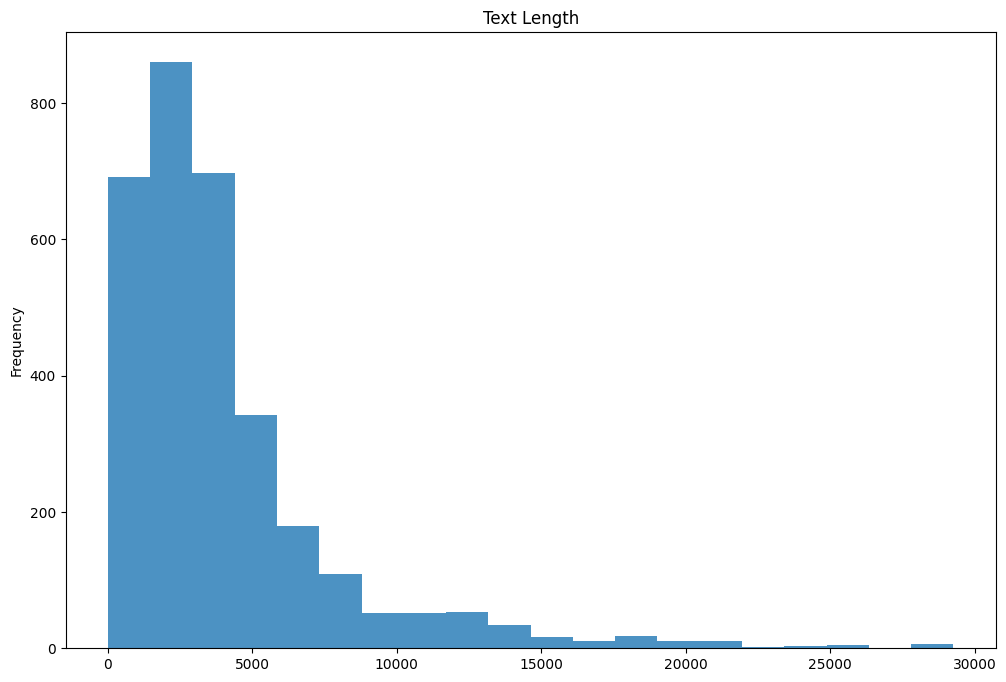

In [38]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.6489088602394992


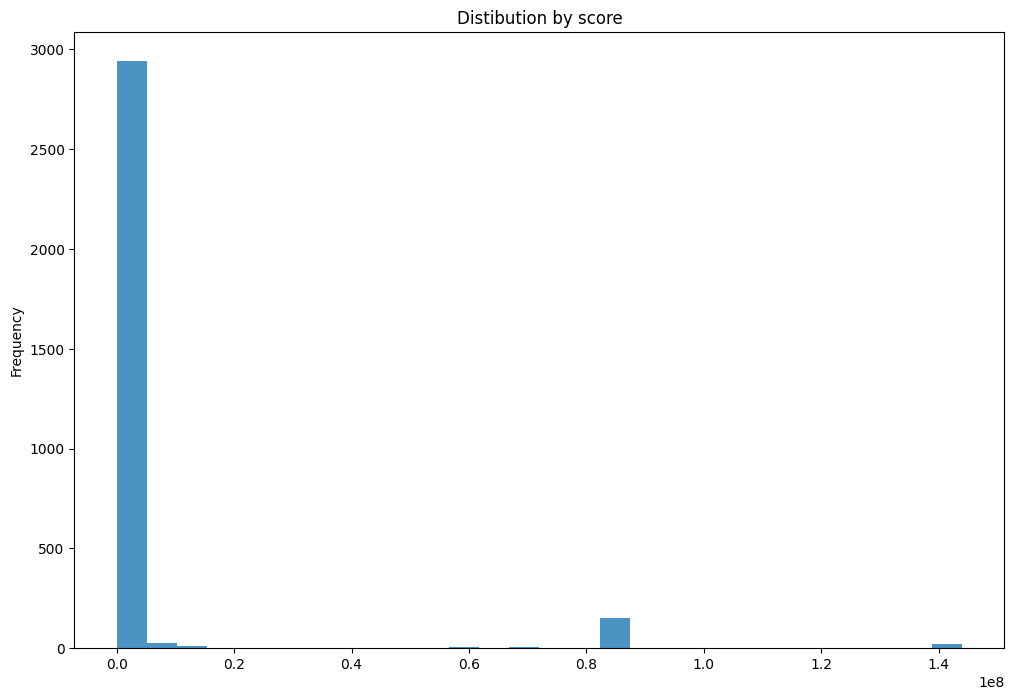

In [39]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [40]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', i, row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 3:
            print ('excluding', i, row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding 5e58df7823869ee43538823d file GeneralContract 31090.0
excluding 5fbf75c75d05d73d0295fac0 db GeneralContract 38360.0
excluding 5fca2acd9083b679224c77da db GeneralContract 49040.0
excluding 5fca2ac89083b679224c7786 db GeneralContract 43930.0
excluding 5fca2ac79083b679224c774f db GeneralContract 39310.0
excluding 5f9672f182451803b5001df7 db GeneralContract 31170.0
excluding 5e5de70d01c6c73c19eebd4a file GeneralContract 31090.0
excluding 5fc7a047c54bc33809e26372 db Service 49340.0
excluding 5f09a55a138e9184feef1f3d file Service 39860.0
excluding 615e9e978f3b0514f3f42413 db Loans 35800.0
excluding 63ce4ac2e83d1ee490f3fd05 db Other 35560.0
excluding 5fb3b9a800881c332b567433 db nan 44180.0
excluding docs with rare subj
excluding 5feb3e50bd24992aa31040df db AssetTransactions
excluding 5fbbbd1ba2b4551c06107a3d db BigDeal
excluding 5dee80604ddc27bcf92dd88e file EmployeeContracts
excluding 6166dbc387f1d9065bb8b937 db AssetTransactions
excluding 610d2b0d7dfce422c4

Service                              1607
Other                                 413
Deal                                  379
Renting                               150
GeneralContract                       145
Loans                                 104
AgencyContract                         79
DealIntellectualProperty               65
Charity                                50
Insurance                              44
RealEstate                             31
RealEstateTransactions                 17
BankGuarantees                         16
PledgeEncumbrance                      12
ParticipationInOtherOrganizations      12
SecuritiesTransactions                  8
Name: subject, dtype: int64


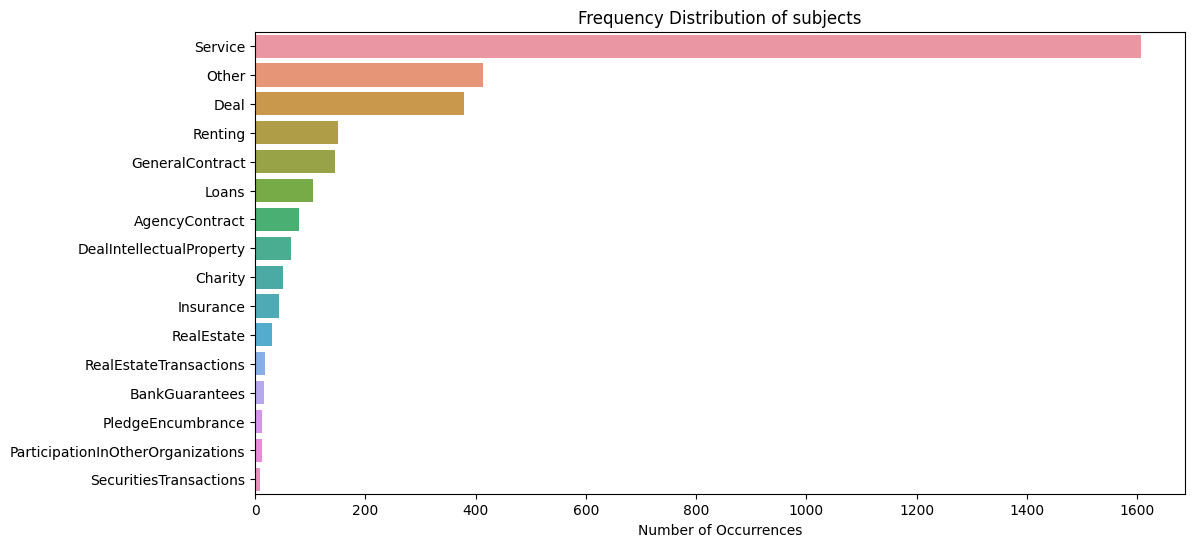

In [41]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 6 ))
sns.barplot(x=cnt.values, y=cnt.index)

print(  cnt )

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


In [42]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate}"
display(Markdown(_s))


dups_s

### 3151 - Всего новых документов в обучающем наборе на 2023-02-09 09:33:18.317000+00:00

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,valid,documentType,subj_len,headers,subject_pos,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,True,CONTRACT,79.0,4.0,1444.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.489089e-01,1.466727e+18,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-15 19:40:44.884996,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,True,CONTRACT,106.0,10.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.552332e-01,7.820601e+18,1.0
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-15 19:40:41.177191,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,True,CONTRACT,30.0,5.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,7.597030e-01,6.378618e+18,1.0
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8530.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,True,CONTRACT,53.0,12.0,100.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.153584e+00,-8.785895e+18,1.0
62dfbce15d5a202ba67b842d,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-15 19:41:01.685099,5550.0,2022-07-26 13:08:03.309000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,True,CONTRACT,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/62df...,False,1.746836e+00,-5.929322e+18,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60890e6294a1f9b4c8a71405,db,5a19ae3f1e7f137fcbea430a082c7abb,2.3.14,2023-01-31 18:37:43.581524,130.0,2021-04-28 10:30:55.292000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,2.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6089...,True,1.440000e+08,4.689905e+18,1.0
5fb278c4d8c9df1ed1236d73,db,8211a8631eb46acc91f6a392e56c6f2a,2.5.3,2023-01-31 18:37:59.053524,150.0,2021-10-27 11:23:17.395000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,2.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb2...,True,1.440000e+08,6.647221e+16,9.0
6285f525f098f73e14297f98,db,1209b403e2ff9f0502d1f57d163fefb9,3.0.0,2023-01-31 18:38:00.272988,460.0,2022-05-19 10:50:24.979000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,2.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,True,1.440000e+08,-5.572481e+18,3.0


In [43]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [44]:
dups_s[dups_s['unseen']]

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,valid,documentType,subj_len,headers,subject_pos,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8d8665f7603e03b121a,db,74a7be7f14b129ce379aaa0920978a71,1.6.5,2023-01-31 18:32:27.217863,550.0,2020-05-18 16:35:16.047000+00:00,4.900000e+05,13.102163,114.0,RUB,...,True,CONTRACT,35.0,7.0,97.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,True,9.722266e+00,5.392170e+17,5.0
63c506c1e2456d59975e1186,db,99eb2f07e9493a1e712529bc30359204,23.2.7,2023-02-14 15:40:13.352394,10780.0,2023-02-07 17:29:02.773000+00:00,6.000000e+06,15.607270,4608.0,RUB,...,True,CONTRACT,35.0,24.0,1656.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,1.558302e+01,3.879806e+18,1.0
639321e71002115a6029f3e3,db,af562294c398fbe27ab3b0c828e40d8c,22.12.7,2023-01-31 18:32:56.741256,3630.0,2022-12-09 14:55:59.385000+00:00,4.000000e+06,15.201805,326.0,RUB,...,True,CONTRACT,95.0,7.0,157.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6393...,True,3.112603e+01,5.347776e+18,2.0
63c506ace2456d59975e0f9f,db,2ff69a29f2a6f16826a6e68dc6cc1d22,23.01.04,2023-01-31 21:42:49.474166,430.0,2023-01-16 14:43:58.035000+00:00,5.500000e+07,17.822844,172.0,RUB,...,True,SUPPLEMENTARY_AGREEMENT,10.0,5.0,136.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,6.803945e+01,1.747379e+18,1.0
5efe924d777d4b67a92d55b0,file,c056d218b8ae1d56747afd23ac3cf10f,2.0.0,2023-02-15 19:40:53.244946,17580.0,2020-07-03 12:29:32.528000+00:00,1.865870e+08,19.044408,2372.0,RUB,...,True,CONTRACT,11.0,76.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5efe...,True,7.417005e+01,-6.390471e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60890e6294a1f9b4c8a71405,db,5a19ae3f1e7f137fcbea430a082c7abb,2.3.14,2023-01-31 18:37:43.581524,130.0,2021-04-28 10:30:55.292000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,2.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6089...,True,1.440000e+08,4.689905e+18,1.0
5fb278c4d8c9df1ed1236d73,db,8211a8631eb46acc91f6a392e56c6f2a,2.5.3,2023-01-31 18:37:59.053524,150.0,2021-10-27 11:23:17.395000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,2.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb2...,True,1.440000e+08,6.647221e+16,9.0
6285f525f098f73e14297f98,db,1209b403e2ff9f0502d1f57d163fefb9,3.0.0,2023-01-31 18:38:00.272988,460.0,2022-05-19 10:50:24.979000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,2.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,True,1.440000e+08,-5.572481e+18,3.0


# 🤦 Find markup errors

In [45]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },      
    {"user.attributes_tree": {"$ne": None}},
#       {'user.updateDate': {'$gt': lastdate}}    
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего документов, которые размечены человеком : {len(res)}"
display(Markdown(_s))

# res[:4]



/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего документов, которые размечены человеком : 1157

In [46]:
user_docs_ids  = [i["_id"] for i in res]
print('user_docs_ids', len(user_docs_ids))


user_docs_ids 1157


In [47]:



def get_span_val(jd:DbJsonDoc, tag):
    tm = jd.get_tokens_map_unchaged()
    
    span = tag.get('span', [0,0]) 
    
    if span[1]-span[0]==0:
        return None
    
    quote = tm.text_range(span)
    
    return quote

def add_error(userdocs, _id, error_message):    
            
    if error_message:
        missing=False
        if len(error_message)==2:
            error_message, missing = error_message
        
        userdocs.at[_id,'errors count'] = userdocs.at[_id,'errors count']+1
        
        if missing==True:
            userdocs.at[_id, 'error missing']=';\n'.join(  [error_message, userdocs.at[_id,'error missing']] )
        else:
            userdocs.at[_id, 'error']=';\n'.join(  [error_message, userdocs.at[_id,'error']] )
        
#--------        

def validate_date(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    tag = jd.get_attributes_tree().get('date', {})
    val = get_span_val(jd, tag)
    
    if not val:
        return
#     val = jd.get_tokens_map_unchaged().text_range(span)
    
    df.at[_id,f'Дата'] = val 
       
    
    if '\n' in val:
        return f"Дата содержит перенос строки"
    
    if len(val) > 25:
        return f"Дата слишком длинная"
    
    
def validate_number(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
#     span = jd.get_attributes_tree().get('number', {}).get('span', [0,0])
#     val = jd.get_tokens_map_unchaged().text_range(span)
    
    tag = jd.get_attributes_tree().get('number', {})
    span = tag.get('span', [0,0]) 
    val = get_span_val(jd, tag)
    
    if not val:
        return
    
    
    df.at[_id,f'Номер'] = val 
    
    if 'договор' in val.lower():
        return f"Номер содержит слово"
    
    if '\n' in val:
        return f"Номер содержит перенос строки"
       
    if val.strip() !=val:
        return f"Номер содержит пробелы по краям"
    
    if val.strip()=="№":
        return f"Номер не является номером"
    
    if (span[1]-span[0])>5:
        return f"Номер договора какой-то длинный"

#     if val.strip()[0]=="№":
#         return f"Номер содержит знак №"
        
#     if len(val) > 30:
#         return f"Номер слишком длинный"
    
    
def validate_alias(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Псевдоним {i+1} отсутсвует", True
    
    tag =  orgs[i].get('alias',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Псевдоним {i+1} отсутсвует", True
    
    
    df.at[_id,f'Псевдоним {i+1}'] = val 
    
    if  '«' in val or '»' in val:
        return f"Псевдоним {i+1} содержит кавычки"
    
    if '\n' in val:
        return f"Псевдоним {i+1} содержит перенос строки"
    
    if len(val) > 25:
        return f"Псевдоним {i+1} слишком длинный"
    
    
def validate_org_name(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Наименование {i+1} отсутсвует", True
    
    tag = orgs[i].get('name',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Наименование {i+1} отсутсвует", True
    
    df.at[_id,f'Наименование {i+1}'] = val 
    
    if '\n' in val:
        return f"Наименование {i+1} содержит перенос строки"
    
    if '«' in val:
        if '»' not in val:
            return f"Наименование {i+1}: кавычка не закрыта"
    
    if '»' in val:
        if '«' not in val:
            return f"Наименование {i+1}: кавычка не открыта"
        
    if val[0]=='«':
        return f"Наименование {i+1} содержит кавычки"
    
    
def validate_org_type(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Форма собственности {i+1} отсутсвует", True
    
    tag = orgs[i].get('type',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Форма собственности {i+1} отсутсвует", True
    
    df.at[_id, f'Форма собственности {i+1}'] = val 
    
    if '\n' in val:
        return f"Форма собственности {i+1}: содержит перенос строки"
    
    if '«' in val:
        if '»' not in val:
            return f"Форма собственности {i+1}: кавычка не закрыта"
    
    if '»' in val:
        if '«' not in val:
            return f"Форма собственности {i+1}: кавычка не открыта"
        
    if val[0]=='«':
        return f"Форма собственности {i+1}: содержит кавычки"
    

def validate_subject_len(jd:DbJsonDoc, df) -> str or None: 
    _id = str(jd._id)
    
    tag = jd.get_attributes_tree().get('subject', {})
    val = get_span_val(jd, tag)
    span = tag.get('span', [0,0]) 
    
    kind = tag.get('value', None) 
    
    
    subject_len = span[1]-span[0]
    
    df.at[_id,'subject len'] = subject_len
    df.at[_id,'subject kind'] = kind
    
    if subject_len > 150:
        df.at[_id,'subject'] = val[:200]
        return f"предмет договора слишком длинный: {subject_len} слов"
    
    if subject_len ==0:
        return f"раздел о предмете договора не указан; определен как [{kind}]"
    
    
def validate_price(jd:DbJsonDoc, df) -> str or None:    
    _id = str(jd._id)
    
    tag = jd.get_attributes_tree().get('price', {})
    
    
    span = tag.get('span', [0,0]) 
        
    _len = span[1]-span[0]
    
#     df.at[_id,'subject len'] = subject_len

    
    
    if not tag:
        return 
    
    price_q = get_span_val(jd, tag)
    df.at[_id,'сумма'] = f"{price_q}"
    
    
    sentence_span1 = jd.get_tokens_map_unchaged().sentence_at_index( span[0])
    sentence_span2 = jd.get_tokens_map_unchaged().sentence_at_index( span[1])
    sentence_span = [ sentence_span1[0], sentence_span2[1]]
    
    
    sentence = jd.get_tokens_map_unchaged().text_range(sentence_span)
    
    amount_name = 'сумма (старая)'
    price_name = 'сумма договора'
    
    
    vat = tag.get('vat')    
    if vat:
        val = get_span_val(jd, vat)    
        df.at[_id, 'налог'] = f'{val}'
        
    vat_unit = tag.get('vat_unit')    
    if vat_unit:
        val = get_span_val(jd, vat_unit)    
        df.at[_id,'vat_unit'] = f'{val}'
        

        
    
    amount_netto = tag.get('amount_netto')    
    if amount_netto:
        val = get_span_val(jd, amount_netto)    
        df.at[_id,'сумма без налога'] = f'{val}'
        
    amount = tag.get('amount')  
    
    if amount:
        val = get_span_val(jd, amount)    
        df.at[_id, amount_name] = f'{val}'
     
        
    amount_brutto = tag.get('amount_brutto')    
    if amount_brutto:
        val = get_span_val(jd, amount_brutto)    
        df.at[_id,'сумма с налогом'] = f'{val}'
        
    currency = tag.get('currency')    
    if currency:
        val = get_span_val(jd, currency)    
        df.at[_id,'currency'] = f'{val}'
        
    
    if vat:
        val = get_span_val(jd, vat)    
        if not val[0].isdigit():
            return  f"налог начинается не с цифры"
     
    #----
    if amount_netto:
        _span = amount_netto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"сумма без налога слишком длинная, должна содержать только число"
    
    #----
    if amount_brutto:
        _span = amount_brutto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"сумма c налогом слишком длинная, должна содержать только число"
        
    #----
    if amount:
        _span = amount.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"{amount_name} слишком длинная, должна содержать только число"
    
    
    if amount_netto or amount_brutto:
        if not vat:
            return  f"налог не указан"
    

    if ' штраф ' in sentence.lower() or "страховая сумма " in sentence.lower() or " пени " in sentence.lower() : 
        print('sentence_span', sentence_span, jd.get_tokens_map_unchaged().text_range(sentence_span))
        return  f"сумма вообще не та!!"
        
    if 'ндс' in sentence.lower():
        if not vat:
            return  f"налог не указан"
        
        if not (amount_netto or  amount_brutto):
            return  f"сумма с учетом налога не указана"
        
    if amount_netto or amount_brutto or amount:
        if not currency:
            return  f"валюта не указана"
        
    if vat:
        if not vat_unit:
            return  f"валюта налога не указана"
    
    if tag:
        if not (price_q.strip()[0].isalpha() or price_q.strip()[0].isdigit):
            return  f"раздел о цене начинается не со слова"
        
    if _len > 150:
        return f"{price_name} слишком длинная: {_len} слов"
    
    if _len < 10:
        return f"{price_name} слишком короткая: {_len} слов, нужно: {sentence_span1[1]- sentence_span2[0]}"

####################################### sentence_at_index

def validate_markup(user_docs_ids) -> DataFrame:
  userdocs = DataFrame()
  for k, oid in enumerate(user_docs_ids):
# for k, oid in enumerate(['5fe34f64b770574a005553e6']):    
    _id = str(oid)
    oid = ObjectId(_id)
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
        
    attr_tree = jd.get_attributes_tree()  
#     print('',attr_tree)

    
    userdocs.at[_id,'дата редактирования'] = jd.user['updateDate']
    userdocs.at[_id,'link'] = f'https://gpn-audit.nemosoft.ru/#/audit/edit/{_id}'
    userdocs.at[_id,'error'] = ''
    userdocs.at[_id,'error missing'] = ''
    userdocs.at[_id,'errors count'] = 0

    
    
    if not jd.analysis:
        userdocs.at[_id, 'error'] = "Не анализирован!!"
    
    else:
        add_error(userdocs, _id, validate_subject_len(jd, userdocs) )
        

        add_error(userdocs, _id, validate_org_type(jd, userdocs, 0) )
        add_error(userdocs, _id, validate_org_name(jd, userdocs, 0) )
        add_error(userdocs, _id, validate_alias(jd, userdocs, 0) )
        
        add_error(userdocs, _id, validate_org_type(jd, userdocs, 1) )
        add_error(userdocs, _id, validate_org_name(jd, userdocs, 1) )
        add_error(userdocs, _id, validate_alias(jd, userdocs, 1) )

        add_error(userdocs, _id, validate_date(jd, userdocs) )
        add_error(userdocs, _id, validate_number(jd, userdocs) )
        
        add_error(userdocs, _id, validate_price(jd, userdocs) )
        
  return userdocs
    
userdocs = validate_markup(user_docs_ids)
userdocs=userdocs.sort_values(["errors count"], ascending=False)
userdocs.to_csv("errors.csv", index=True)   

_s = f"#### Всего ошибок: {userdocs['errors count'].sum()} в {len(userdocs)} документах -- ({userdocs['errors count'].sum()/len(userdocs)} на документ)"
display(Markdown(_s))

userdocs

sentence_span [10328, 10403] 1.11 .Поставщик может уступить право требования по настоящему Договору лишь после получения письменного согласия Покупателя. Письменное согласие Покупателя оформляется путем подписания со стороны Покупателя Уведомления об уступке прав требования. В случае оформления уступки права требования по настоящему Договору Поставщик без наличия письменного согласия Покупателя, последний вправе не согласиться с совершенной уступкой и взыскать с Поставщика штраф в размере 100000 (сто тысяч) рублей за каждый случай уступки права требования.

sentence_span [780, 803] 3.2. Общая страховая сумма по настоящему Договору составляет 296250000 (Двести девяносто шесть миллионов двести пятьдесят тысяч) рублей 00 копеек

sentence_span [780, 803] 3.2. Общая страховая сумма по настоящему Договору составляет 296250000 (Двести девяносто шесть миллионов двести пятьдесят тысяч) рублей 00 копеек



#### Всего ошибок: 1263.0 в 1157 документах -- (1.0916162489196197 на документ)

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,Дата,сумма,сумма (старая),currency,Номер,сумма без налога,налог,vat_unit,сумма с налогом,subject
63ce4a56e83d1ee490f3f790,2023-02-12 09:08:11.045,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,раздел о предмете договора не указан; определе...,Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...,7.0,0.0,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152e3af8558145da68d8790,2023-02-15 16:29:51.796,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,налог не указан;\n,Наименование 2 отсутсвует;\nФорма собственност...,5.0,56.0,Service,NaN,NaN,Заказчик,...,NaN,"Общая стоимость услуг по Договору составляет, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615ac8cf8f3b0514f3f423f8,2021-10-04 09:30:37.752,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Номер не является номером;\n,Псевдоним 2 отсутсвует;\nПсевдоним 1 отсутсвуе...,5.0,37.0,Service,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,№,NaN,NaN,NaN,NaN,NaN
5fb3d7a978df3635f5441ebb,2021-10-27 17:31:00.594,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,налог не указан;\nНомер не является номером;\n...,,4.0,0.0,None,Общество с ограниченной ответственностью,Газпромнефть-Развитие,Заказчик,...,NaN,Стоимость Услуг по настоящему Договору составл...,NaN,рублей,№,309690,NaN,NaN,371628,NaN
638085a16a07f3e980b2c5f0,2022-11-28 14:12:32.757,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,налог не указан;\nНомер не является номером;\n,Наименование 2 отсутсвует;\nФорма собственност...,4.0,81.0,Service,Общество с ограниченной ответственностью,ГПН-Аэро,Заказчик,...,«25» октября 2021,5.6 Общая стоимость настоящего договора в теч...,NaN,рублей,№,500,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fbbe469a2b4551c06107b8d,2022-12-02 16:47:35.528,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,,0.0,99.0,Deal,Акционерное общество,Арктика Медиа,Исполнитель,...,25-02-2019,NaN,NaN,NaN,№ 19-04Д,NaN,NaN,NaN,NaN,NaN
5fbbe466a2b4551c06107ae1,2020-11-24 08:55:45.658,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,,0.0,29.0,Service,Акционерное общество,Арктика Медиа,Заказчик,...,«20» Февраля 2019,NaN,NaN,NaN,№ 19/02-03,NaN,NaN,NaN,NaN,NaN
638085a96a07f3e980b2c6cc,2022-11-29 10:31:27.110,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,29.0,Deal,АО,Фунтик,Поставщик,...,1 сентября 2021,NaN,NaN,NaN,№ 777,NaN,NaN,NaN,NaN,NaN
638085a86a07f3e980b2c6b5,2022-11-29 14:14:04.008,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,37.0,DealIntellectualProperty,ООО,ААА,Покупатель,...,«20» апреля 2021,3.1. Общая стоимость программного обеспечения ...,NaN,рублей,№ 1,NaN,"1,6",рублей,8,NaN


In [48]:
yseterday_userdocs = validate_markup(yseterday_ids)
yseterday_userdocs.to_csv("yesterday_errors.csv", index=True)   

yseterday_userdocs

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Псевдоним 1,Псевдоним 2,сумма,...,Наименование 1,Форма собственности 2,Наименование 2,Дата,сумма без налога,currency,Номер,налог,vat_unit,сумма с налогом
6152e3798558145da68d8788,2023-02-15 16:30:42.431,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,Наименование 2 отсутсвует;\nФорма собственност...,4.0,42.0,Service,Клиент,Актуарий,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152e3af8558145da68d8790,2023-02-15 16:29:51.796,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,налог не указан;\n,Наименование 2 отсутсвует;\nФорма собственност...,5.0,56.0,Service,Заказчик,Исполнитель,"Общая стоимость услуг по Договору составляет, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63c506bbe2456d59975e10d7,2023-02-15 16:27:27.873,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,налог не указан;\n,,1.0,65.0,Charity,Благотворитель,Благополучатель,2.1. «Благотворитель» обязуется передать «Благ...,...,Ромашка,Фонд культурных инициатив,Лютик,«24» октября 2018 год,10,рублей,NaN,NaN,NaN,NaN
63c506cce2456d59975e12c3,2023-02-15 16:28:54.413,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,налог не указан;\n,,1.0,43.0,Deal,Поставщик,Покупатель,3.3. Общий размер стоимости всех Заявок по нас...,...,Рога и копыта,ООО,Ромашка,«04» октября 2017 год.,10,рублей,NaN,NaN,NaN,NaN
6285f525f098f73e14297f93,2023-02-15 16:34:41.195,https://gpn-audit.nemosoft.ru/#/audit/edit/628...,Наименование 2: кавычка не закрыта;\nНаименова...,,3.0,0.0,None,Поставщик,Покупатель,Цена Договора определяется спецификацией и сос...,...,Издательско-полиграфическое предприятие «Масте...,Акционерное Общество,Страховая компания «СОГАЗ-Мед,«20» августа 2020,NaN,рублей,№ 36/09-2020,20,%,"43680,00"
615ac8b28f3b0514f3f423f2,2023-02-15 16:35:24.214,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,Форма собственности 2 отсутсвует;\n,1.0,48.0,Service,Заказчик,Исполнитель,NaN,...,Газпром нефть,NaN,Дошлова Юлия Владимировна,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fe4821db770574a005556d1,2023-02-15 16:38:54.586,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,Наименование 2: кавычка не закрыта;\nНаименова...,,2.0,37.0,Deal,Поставщик,Покупатель,Цена Договора определяется спецификацией и сос...,...,Издательско-полиграфическое предприятие «Масте...,Акционерное Общество,Страховая компания «СОГАЗ-Мед,«20» августа 2020,NaN,рублей,№ 36/09-2020,20,%,"43680,00"


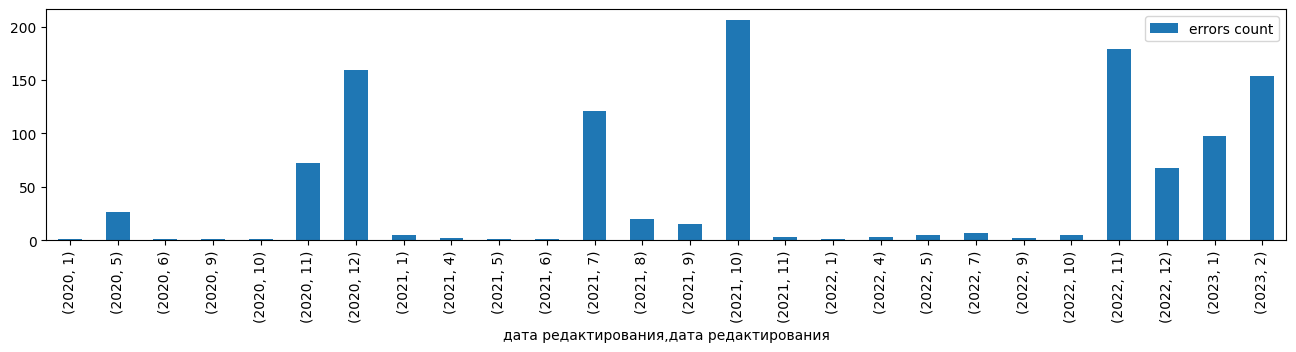

In [49]:
# userdocs.groupby(userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month) [['errors count','дата редактирования']] .count().plot(kind="bar")
import matplotlib.pyplot as plt


ax = userdocs.groupby(
    [userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month ])[
        ['errors count']].count().plot(kind="bar", figsize=(16,3))

plt.show()

In [50]:
userdocsBak = userdocs.copy()

In [51]:
from collections import Counter


l = list(userdocs['vat_unit'].values) + list( userdocs['currency'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_currency=[]
for k in c:
    if c[k] < 2:
        rare_currency.append(k)
        

l = list(userdocs['Псевдоним 1'].values) + list( userdocs['Псевдоним 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_aliases=[]
for k in c:
    if c[k] < 2:
        rare_aliases.append(k)
# rare_aliases


l = list(userdocs['Форма собственности 1'].values) + list( userdocs['Форма собственности 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_forms=[]
for k in c:
    if c[k] < 2:
        rare_forms.append(k)
# print(rare_forms)        
        
    
    
for i, row in userdocs.iterrows():
    fs1 = str(row['Форма собственности 1']).lower()
    fs2 = str(row['Форма собственности 2']).lower()
    
    as1 = str(row['Псевдоним 1']).lower()
    as2 = str(row['Псевдоним 2']).lower()
    
    
    cs1 = str(row['vat_unit']).lower()
    if cs1 in rare_currency:
        print(i, f'[{cs1}]')
        add_error(userdocs, i, "Валюта налога очень странная" )
        
    cs2 = str(row['currency']).lower()
    if cs2 in rare_currency:
        print(i, f'[{cs2}]')
        add_error(userdocs, i, "Валюта очень странная" )
    
    if fs1 in rare_forms:
        print(i, f'[{fs1}]')
        add_error(userdocs, i, "Форма собственности 1 очень странная" )
    if fs2 in rare_forms:
        print(i, f'[{fs2}]')
        add_error(userdocs, i, "Форма собственности 2 очень странная" )
        
    if as1 in rare_aliases:
        print(i, f'[{as1}]')
        add_error(userdocs, i, "Псевдоним 1 очень странный" )
    if as2 in rare_aliases:
        print(i, f'[{as2}]')
        add_error(userdocs, i, "Псевдоним 2 очень странный" )
        
userdocs

612de89f4f22ff1b7e02fcd7 [eur]
6152e3798558145da68d8788 [актуарий]
5fb3d79e78df3635f5441d1e [общество с ограниченной ответе венностью]
5fb3d4a078df3635f5441c32 [муниципальное автономное учреждение культуры]
6380855c6a07f3e980b2c061 [ромашка]
5fe4821ab770574a00555657 [общественная организация «спортивная общественная организация]
62874fcd4d1bfe5e5b297df0 [ндс]
62d149484ae369b4976e31ff [долларов сша]
5fca2aab9083b679224c75e7 [газпромнефть-оренбург]
6380858a6a07f3e980b2c4aa [исполнитель или подрядчик]
638085706a07f3e980b2c1ed [акционерное общество (ао )]
5fe4821eb770574a00555708 [общественная организация]
5fe48218b770574a005555c6 [муниципальное унитарное предприятие]
5fdb2143542ce403c92b45a1 [зарегистрированный кандидат в депутаты]
63a40a76327b0fecf75ecb40 [
 публичное акционерное общество]
5fbbe46da2b4551c06107c68 [теплоснабжающая организация]
5fb3d4a078df3635f5441c6d [общество с гветственностью]
638085826a07f3e980b2c3b8 [общество с ограниченной отвественностью]
6294ae67df54d406a99b1631 

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,Дата,сумма,сумма (старая),currency,Номер,сумма без налога,налог,vat_unit,сумма с налогом,subject
63ce4a56e83d1ee490f3f790,2023-02-12 09:08:11.045,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,раздел о предмете договора не указан; определе...,Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...,7.0,0.0,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152e3af8558145da68d8790,2023-02-15 16:29:51.796,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,налог не указан;\n,Наименование 2 отсутсвует;\nФорма собственност...,5.0,56.0,Service,NaN,NaN,Заказчик,...,NaN,"Общая стоимость услуг по Договору составляет, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615ac8cf8f3b0514f3f423f8,2021-10-04 09:30:37.752,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Номер не является номером;\n,Псевдоним 2 отсутсвует;\nПсевдоним 1 отсутсвуе...,5.0,37.0,Service,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,№,NaN,NaN,NaN,NaN,NaN
5fb3d7a978df3635f5441ebb,2021-10-27 17:31:00.594,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,налог не указан;\nНомер не является номером;\n...,,4.0,0.0,None,Общество с ограниченной ответственностью,Газпромнефть-Развитие,Заказчик,...,NaN,Стоимость Услуг по настоящему Договору составл...,NaN,рублей,№,309690,NaN,NaN,371628,NaN
638085a16a07f3e980b2c5f0,2022-11-28 14:12:32.757,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,налог не указан;\nНомер не является номером;\n,Наименование 2 отсутсвует;\nФорма собственност...,4.0,81.0,Service,Общество с ограниченной ответственностью,ГПН-Аэро,Заказчик,...,«25» октября 2021,5.6 Общая стоимость настоящего договора в теч...,NaN,рублей,№,500,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fbbe469a2b4551c06107b8d,2022-12-02 16:47:35.528,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,,0.0,99.0,Deal,Акционерное общество,Арктика Медиа,Исполнитель,...,25-02-2019,NaN,NaN,NaN,№ 19-04Д,NaN,NaN,NaN,NaN,NaN
5fbbe466a2b4551c06107ae1,2020-11-24 08:55:45.658,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,,0.0,29.0,Service,Акционерное общество,Арктика Медиа,Заказчик,...,«20» Февраля 2019,NaN,NaN,NaN,№ 19/02-03,NaN,NaN,NaN,NaN,NaN
638085a96a07f3e980b2c6cc,2022-11-29 10:31:27.110,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,29.0,Deal,АО,Фунтик,Поставщик,...,1 сентября 2021,NaN,NaN,NaN,№ 777,NaN,NaN,NaN,NaN,NaN
638085a86a07f3e980b2c6b5,2022-11-29 14:14:04.008,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,37.0,DealIntellectualProperty,ООО,ААА,Покупатель,...,«20» апреля 2021,3.1. Общая стоимость программного обеспечения ...,NaN,рублей,№ 1,NaN,"1,6",рублей,8,NaN


In [52]:

userdocs=userdocs.sort_values(["errors count"], ascending=False)
userdocs.to_csv("errors.csv", index=True)     
# userdocs



In [53]:
userdocs_subj = userdocs[ ['subject kind', 'Псевдоним 1', 'Псевдоним 2']]
# userdocs_subj

def get_alias_pair(v):
    return ' -vs- '.join(   np.sort( list([ str(v['Псевдоним 1']).lower(), str(v['Псевдоним 2']).lower()])) ) 


 
c=Counter([get_alias_pair(v) for i, v in userdocs_subj.iterrows()])
rare_aliases_pairs=[k for k in c if c[k] < 2]
for i, row in userdocs.iterrows():
    d=get_alias_pair(row)
    if d in rare_aliases_pairs:
        print(i, f'[{d}]')
        userdocs.at[i, 'strange alias combo'] =f"Необычная пара псевдонимов: {d}"
        
print('-'*20)
del rare_aliases_pairs
# # rare_aliases_pairs
        
# del d
    
def get_alias_subject_pair(v, i):
    return ' / '.join(    list([ str(v[f'Псевдоним {i}']).lower(), str(v['subject kind']).lower()])) 
    
p1 = [get_alias_subject_pair(v, 1) for i, v in userdocs_subj.iterrows()]


c=Counter(p1+[get_alias_subject_pair(v, 2) for i, v in userdocs_subj.iterrows()])
rare_alias_subj_pairs=[k for k in c if c[k] < 3]

for i, row in userdocs.iterrows():
    d1 = get_alias_subject_pair(row, 1)
    d2 = get_alias_subject_pair(row, 2)
    
    if d1 in rare_alias_subj_pairs:
        print(i, f'[{d1}]')
        userdocs.at[i, 'strange alias-subject'] =f"Необычная пара псевдоним-предмет: {d1}"
    
    if d2 in rare_alias_subj_pairs :
        print(i, f'[{d2}]')
        userdocs.at[i, 'strange alias-subject'] =f"Необычная пара псевдоним-предмет: {d2}"
        
print('-'*20)        
rare_alias_subj_pairs


6152e3798558145da68d8788 [актуарий -vs- клиент]
612de89f4f22ff1b7e02fcd7 [nan -vs- покупатель]
6380855c6a07f3e980b2c061 [клуб -vs- ромашка]
5ec2b8da665f7603e03b1255 [sun -vs- гпн]
6294ae67df54d406a99b1631 [водопользователь -vs- уполномоченный орган]
5fca2ab09083b679224c7638 [заказии -vs- исполнитель]
62c54895e599c73b751b7974 [nan -vs- клуб]
635fa420bf4cb23cbb39282f [жертвователь -vs- жертвополучатель]
63ce49f8e83d1ee490f3f21c [банк -vs- приказодатель]
63c506c9e2456d59975e1277 [газпромнефть - 123 -vs- правительство]
5fbbe46da2b4551c06107c68 [потребитель -vs- теплоснабжающая организация]
6380858a6a07f3e980b2c4aa [заказчик -vs- исполнитель или подрядчик]
63908ca4a1bded13e629f2ea [nan -vs- гарант]
5fb6750633c72547b755009c [вещатель -vs- оператор связи]
6380855b6a07f3e980b2c042 [благотворитель -vs- получатель]
5ec2b8d9665f7603e03b1234 [получатель -vs- спонсор]
638085766a07f3e980b2c280 [клиент -vs- перевозчик]
5fe4821ab770574a00555625 [грузополучатель -vs- поставщик]
635fa420bf4cb23cbb39282d

['ромашка / deal',
 'гпн / service',
 'водопользователь / none',
 'заказии / service',
 'nan / deal',
 'газпромнефть - 123 / deal',
 'потребитель / deal',
 'энергоснабжающая организация / service',
 'nan / agencycontract',
 'страхователь / none',
 'спонсор / charity',
 'ссудополучатель / renting',
 'заявитель / service',
 'предприятие / service',
 'арендодатель / none',
 'сторона 2 / service',
 'подрядчик / deal',
 'плательщик / charity',
 'клиент^ / service',
 'подписчик / service',
 'экспедитор / service',
 'абонент / deal',
 'таможенный представитель / service',
 'арендатор / none',
 'правообладатель / deal',
 'сторона-2 / service',
 'потребитель / service',
 'общество / assettransactions',
 'сторона-1 / dealintellectualproperty',
 'пользователь / dealintellectualproperty',
 'организатор / service',
 'владелец / принципал / agencycontract',
 'заявитель / bankguarantees',
 'клиент / bankguarantees',
 'покупатель / assettransactions',
 'актуарий / service',
 'клуб / deal',
 'sun / ser

In [54]:
_s = f"#### {datetime.today().strftime('%d.%m.%Y')} *Всего* ошибок, недочетов и проч.: {userdocs['errors count'].sum()} в {len(userdocs)} документах -- ({userdocs['errors count'].sum()/len(userdocs):0.2f} на документ)"
display(Markdown(_s))

#### 15.02.2023 *Всего* ошибок, недочетов и проч.: 1372.0 в 1157 документах -- (1.19 на документ)

In [55]:
userdocs_subj = userdocs[ ['link','subject kind', 'Псевдоним 1', 'Псевдоним 2', 'strange alias combo', 'strange alias-subject' ]]

errors_subjects = userdocs_subj[userdocs_subj['strange alias combo'].notnull() | userdocs_subj['strange alias-subject'].notnull() ]
errors_subjects.to_csv("errors_subjects.csv", index=True)         
errors_subjects

,link,subject kind,Псевдоним 1,Псевдоним 2,strange alias combo,strange alias-subject
6152e3798558145da68d8788,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Service,Клиент,Актуарий,Необычная пара псевдонимов: актуарий -vs- клиент,Необычная пара псевдоним-предмет: актуарий / s...
612de89f4f22ff1b7e02fcd7,https://gpn-audit.nemosoft.ru/#/audit/edit/612...,Deal,ПОКУПАТЕЛЬ,NaN,Необычная пара псевдонимов: nan -vs- покупатель,Необычная пара псевдоним-предмет: nan / deal
6380855c6a07f3e980b2c061,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,Deal,Ромашка,Клуб,Необычная пара псевдонимов: клуб -vs- ромашка,Необычная пара псевдоним-предмет: клуб / deal
5ec2b8da665f7603e03b1255,https://gpn-audit.nemosoft.ru/#/audit/edit/5ec...,Service,ГПН,SUN,Необычная пара псевдонимов: sun -vs- гпн,Необычная пара псевдоним-предмет: sun / service
6294ae67df54d406a99b1631,https://gpn-audit.nemosoft.ru/#/audit/edit/629...,None,Водопользователь,Уполномоченный орган,Необычная пара псевдонимов: водопользователь -...,Необычная пара псевдоним-предмет: уполномоченн...
...,...,...,...,...,...,...
638085b86a07f3e980b2c860,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,Service,Оператор,Компания,Необычная пара псевдонимов: компания -vs- опер...,NaN
62d149484ae369b4976e3202,https://gpn-audit.nemosoft.ru/#/audit/edit/62d...,Service,ОБЩЕСТВО,ХРАНТРАНСНЕФТЬ,NaN,Необычная пара псевдоним-предмет: хрантранснеф...
63be916f6ba909ce9c6bfe5b,https://gpn-audit.nemosoft.ru/#/audit/edit/63b...,BankGuarantees,Клиент,Банк,NaN,Необычная пара псевдоним-предмет: клиент / ban...
5fc7a034c54bc33809e261a8,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,Service,Сторона 2,Сторона 1,NaN,Необычная пара псевдоним-предмет: сторона 1 / ...


In [56]:
userdocs[userdocs['errors count']<2]

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,сумма (старая),currency,Номер,сумма без налога,налог,vat_unit,сумма с налогом,subject,strange alias combo,strange alias-subject
5fca2aac9083b679224c75f6,2023-02-03 08:08:39.352,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,Форма собственности 2: кавычка не закрыта;\n,,1.0,75.0,AgencyContract,Общество с ограниченной ответственностью,Газпромнефть-Оренбург,Принципал,...,NaN,рубль,№ ОРН/20/20000/00436/Р,NaN,610303,рубля,"3661821,12",NaN,NaN,NaN
5ec2b8d8665f7603e03b122b,2023-02-02 14:26:08.111,https://gpn-audit.nemosoft.ru/#/audit/edit/5ec...,налог не указан;\n,,1.0,52.0,Loans,ООО,Газпромнефть Марин Бункер,Займодавец,...,NaN,рублей,ГПН-123 / МБР-123,15000000000=00,NaN,NaN,NaN,NaN,NaN,NaN
5ec2b8da665f7603e03b1272,2020-05-21 14:18:40.374,https://gpn-audit.nemosoft.ru/#/audit/edit/5ec...,налог не указан;\n,,1.0,95.0,Service,ООО,Газпромнефть – КП,Заказчик,...,50850000,рублей,№ 1234567/16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5ec2b8da665f7603e03b1264,2020-05-21 14:17:00.704,https://gpn-audit.nemosoft.ru/#/audit/edit/5ec...,"сумма договора слишком короткая: 5 слов, нужно...",,1.0,30.0,RealEstate,Общество с ограниченной ответственностью,Газпромнефть-Новосибирск (НБ),Продавец,...,9000000,рублей,№ 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5ec2b8d8665f7603e03b1228,2020-05-21 16:44:37.160,https://gpn-audit.nemosoft.ru/#/audit/edit/5ec...,"сумма договора слишком короткая: 5 слов, нужно...",,1.0,46.0,Loans,Акционерное общество,ГПН-ГПН,Займодавец,...,1000000,рублей,N 167/ЗП,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5feb3e51bd24992aa3104108,2020-12-29 15:00:07.153,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,,,0.0,106.0,Insurance,Общество с ограниченной ответственностью,Газпромнефть-Снабжение,Страхователь,...,"300000,00",рублей,№ 159-875-658-ст,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fc63d611d0a1603c7a0c97b,2020-12-18 08:13:09.201,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,,,0.0,66.0,Charity,ООО,Газпромнефть НТЦ,Благотворитель,...,NaN,NaN,№ НТЦ-19/03000/00931,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fc6452a1d0a1603c7a0c9f0,2020-12-16 08:51:56.747,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,,,0.0,71.0,Charity,ООО,Газпромнефть НТЦ,Благотворитель,...,NaN,NaN,№ НТЦ-20/03000/00080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6393256f1002115a6029f3f0,2023-02-04 08:05:50.469,https://gpn-audit.nemosoft.ru/#/audit/edit/639...,,,0.0,18.0,Loans,Общество с ограниченной ответственностью,Газпромнефть-Снабжение,Заемщик,...,3433397000,рублей,19/12100/03616,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Make datapoints

In [60]:
work_dir

PosixPath('/root/artem/work')

In [61]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    print(len(tokens_map))
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    _embeddings_file = _dp_fn(id_, 'embeddings')
    np.save(_embeddings_file, embeddings)
    print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

In [62]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)
# intersection_set




168

### Trainset fixtures
#### Invalidate long subjects

In [63]:
ids = list(dups_s.index)

if not 'subject_pos' in stats:
    stats['subject_pos'] = None
        
ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):

    _id = str(oid)
    iiid= ObjectId(_id)
    
    src = dups_s.loc[_id]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[_id, 'documentType'] = jd.documentType
            dups_s.at[_id, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            stats.at[_id, 'subj_len'] = subject_len
            dups_s.at[_id, 'subj_len'] = subject_len  
            
            stats.at[_id, 'subject_pos'] = span[0]
            dups_s.at[_id, 'subject_pos'] = span[0]  
                
            if span[0]==0:
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
                
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
# stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


3047 63ce4a5ee83d1ee490f3f7ee [0, 200] 200
Приложение № 1 от 26-07-2018 к договору поставки №
3108 63ce4a14e83d1ee490f3f3e0 [0, 200] 200
Приложение № 5 от 30-03-2018 год к договору постав


#### Fix missing headers

In [64]:
from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph
from analyser.ml_tools import SemanticTag
from integration.word_document_parser import join_paragraphs


def save_analysis(db_document: DbJsonDoc, doc_dummie: LegalDocument) -> DbJsonDoc:
  documents_collection = get_mongodb_connection()['documents']
  
  _analyse_json_obj: dict = doc_dummie.to_json_obj()
  print("--analyse_json_obj['headers'] len=", len(_analyse_json_obj['headers']))

#   to_save = db_document.as_dict()
#   to_save['headers'] = _analyse_json_obj['headers']

  documents_collection.update_one({'_id': doc_dummie.get_id()}, {'$set': {'analysis.headers': _analyse_json_obj['headers']}})
 
    
  print("updated", doc_dummie.get_id())


def restore_headers (response, oid) :
  doc = join_paragraphs(response, oid)
  return doc
   


def restore_headlines(k, oid):    

    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state in [15,12]:
                if len(jd.analysis.get('headers', [])) > 0:
                    #  all is ok
#                     print(oid)
                    pass
                else:
                     doc_with_paragraphs = restore_headers(jd.parse, iiid)
                     save_analysis(jd,  doc_with_paragraphs)
                     print ('--', k, oid, len(doc_with_paragraphs.paragraphs))

                    
for k, oid in enumerate(ids):
    restore_headlines(k,oid)


In [65]:
# restore_headlines(1,'62d149474ae369b4976e31fc'): 

In [66]:
len(ids_of_long_subject_docs)

2

In [67]:
dups_s

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,valid,documentType,subj_len,headers,subject_pos,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,True,CONTRACT,79.0,4.0,1444.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.489089e-01,7.304797e+17,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-12 11:44:34.758908,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,True,CONTRACT,106.0,10.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.552332e-01,5.264409e+18,1.0
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-12 11:44:31.192516,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,True,CONTRACT,30.0,5.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,7.597030e-01,6.675488e+18,1.0
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8530.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,True,CONTRACT,53.0,12.0,100.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.153584e+00,-5.806427e+18,1.0
6246a3fa25a983726c7694af,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-01-31 18:32:42.511519,5550.0,2022-04-01 10:21:21.897000+00:00,1.000000e+11,25.328436,1505.0,NaN,...,True,CONTRACT,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6246...,False,1.746836e+00,8.600536e+18,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb3d49e78df3635f5441bdb,db,2173bdd6f2682224fa7ea6750ee97ee4,2.4.4,2023-01-31 18:37:43.883547,160.0,2021-07-23 10:50:01.700000+00:00,NaN,NaN,NaN,NaN,...,False,ANNEX,0.0,4.0,0.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,2.647569e+18,14.0
5fb376e7d8c9df1ed1237351,db,81977b58474ab64d729d9b8dfe5f53c3,2.5.3,2023-01-31 18:37:59.250522,120.0,2021-10-28 15:53:03.858000+00:00,NaN,NaN,NaN,NaN,...,False,ANNEX,0.0,5.0,0.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,1.429407e+18,13.0
5fb6750a33c72547b7550117,db,d739ca725a4e1dd27b9c601cd983364a,2.4.4,2023-01-31 18:37:44.256163,140.0,2021-07-28 18:18:48.243000+00:00,NaN,NaN,NaN,NaN,...,False,ANNEX,0.0,2.0,0.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,8.305693e+18,20.0


In [68]:
stats.to_csv(export_fn, index=True)

# Main sequence

In [71]:

for k, oid in enumerate(list(ids)):
# for k, oid in enumerate(list(intersection_set)): #enumerate(ids): 
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


5ec2b8da665f7603e03b1255 0 of 3163 db
5847
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1255-datapoint-embeddings.npy (5847, 1024)
5edbc62eda3678279fbcadf3 1 of 3163 file
5edbc62eda3678279fbcadf3 1 of 3163 file
1373
embeddings saved to /root/artem/work/datasets/5edbc62eda3678279fbcadf3-datapoint-embeddings.npy (1373, 1024)
5ded4e284ddc27bcf92dd6ce 2 of 3163 file
5ded4e284ddc27bcf92dd6ce 2 of 3163 file
460
embeddings saved to /root/artem/work/datasets/5ded4e284ddc27bcf92dd6ce-datapoint-embeddings.npy (460, 1024)
63ce49f8e83d1ee490f3f21c 3 of 3163 db
8535
embeddings saved to /root/artem/work/datasets/63ce49f8e83d1ee490f3f21c-datapoint-embeddings.npy (8535, 1024)
6246a3fa25a983726c7694af 4 of 3163 db
5556
embeddings saved to /root/artem/work/datasets/6246a3fa25a983726c7694af-datapoint-embeddings.npy (5556, 1024)
63908ca4a1bded13e629f2eb 5 of 3163 db
13410
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2eb-datapoint-embeddings.npy (13410, 1024)
6390

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a2ce83d1ee490f3f4e4 chs=14c02c07481c7a5f7b09579a5fc83888
[embedder_elmo.py:50 - _build_session_and_graph() ] < loading ELMO module https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz
[embedder_elmo.py:51 - _build_session_and_graph() ] TF hub cache dir is  /root/artem/work/tf_cache
INFO:absl:Using /root/artem/work/tf_cache to cache modules.


embeddings saved to /root/artem/work/datasets/638085666a07f3e980b2c115-datapoint-embeddings.npy (2199, 1024)
63ce4a2ce83d1ee490f3f4e4 2994 of 3163 db
144


[embedder_elmo.py:53 - _build_session_and_graph() ] ELMO module loaded >
INFO:gpn:ELMO module loaded >
[embedder_elmo.py:68 - _build_session_and_graph() ] ELMO: creating embedded_out_elmo
INFO:gpn:ELMO: creating embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[embedder_elmo.py:74 - _build_session_and_graph() ] ELMO: embedded_out_defaut embedded_out_elmo
INFO:gpn:ELMO: embedded_out_defaut embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2023-02-12 12:02:55.499936: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-12 12:02:56.269784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 12:02:56.270781: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-12 12:02:56.270815: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-12 12:02:56.270868: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic libra

embeddings saved to /root/artem/work/datasets/63ce4a2ce83d1ee490f3f4e4-datapoint-embeddings.npy (144, 1024)
63c506dce2456d59975e1451 2995 of 3163 db
174


DEBUG:gpn:skipping embedding doc bb76a84b3e837d76338953cdb27578a7 ...., /root/artem/work/datasets/cache-bb76a84b3e837d76338953cdb27578a7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5452, 1024)
DEBUG:gpn:getting embedding from cache id=6380856d6a07f3e980b2c19f chs=bb76a84b3e837d76338953cdb27578a7
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a65e83d1ee490f3f84d chs=1cc9444859232eca76bad37ce2312d3b
INFO:gpn:embedding doc id=63ce4a65e83d1ee490f3f84d chs=1cc9444859232eca76bad37ce2312d3b


embeddings saved to /root/artem/work/datasets/63c506dce2456d59975e1451-datapoint-embeddings.npy (174, 1024)
6380856d6a07f3e980b2c19f 2996 of 3163 db
5452
embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c19f-datapoint-embeddings.npy (5452, 1024)
63ce4a65e83d1ee490f3f84d 2997 of 3163 db
259


DEBUG:gpn:skipping embedding doc 2e4fafb6a475771a8f18ed6b8a7672d7 ...., /root/artem/work/datasets/cache-2e4fafb6a475771a8f18ed6b8a7672d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1609, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4abbe83d1ee490f3fca3 chs=2e4fafb6a475771a8f18ed6b8a7672d7
DEBUG:gpn:skipping embedding doc ee55bf02b9841cf5c25e0e93ced735c4 ...., /root/artem/work/datasets/cache-ee55bf02b9841cf5c25e0e93ced735c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (273, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c411 chs=ee55bf02b9841cf5c25e0e93ced735c4
DEBUG:gpn:skipping embedding doc dad2ef50762f9373eca793d976d87116 ...., /root/artem/work/datasets/cache-dad2ef50762f9373eca793d976d87116-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1322, 1024)
DEBUG:gpn:getting embedding from cache id=63c506a9e2456d59975e0f7f chs=dad2ef50762f9373eca793d976d87

embeddings saved to /root/artem/work/datasets/63ce4a65e83d1ee490f3f84d-datapoint-embeddings.npy (259, 1024)
63ce4abbe83d1ee490f3fca3 2998 of 3163 db
1609
embeddings saved to /root/artem/work/datasets/63ce4abbe83d1ee490f3fca3-datapoint-embeddings.npy (1609, 1024)
638085856a07f3e980b2c411 2999 of 3163 db
273
embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c411-datapoint-embeddings.npy (273, 1024)
63c506a9e2456d59975e0f7f 3000 of 3163 db
1322
embeddings saved to /root/artem/work/datasets/63c506a9e2456d59975e0f7f-datapoint-embeddings.npy (1322, 1024)
63c506b9e2456d59975e10b4 3001 of 3163 db
2536


DEBUG:gpn:loaded embedding shape is: (2536, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b9e2456d59975e10b4 chs=44a434f2b3b5c23f45218aa0d5c5240e
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a0ae83d1ee490f3f34e chs=f48be48485a9eaf5fa16ee57de581b46
INFO:gpn:embedding doc id=63ce4a0ae83d1ee490f3f34e chs=f48be48485a9eaf5fa16ee57de581b46
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085876a07f3e980b2c459 chs=9f48ecd88ee14366cac3bc87943e51f6
INFO:gpn:embedding doc id=638085876a07f3e980b2c459 chs=9f48ecd88ee14366cac3bc87943e51f6


embeddings saved to /root/artem/work/datasets/63c506b9e2456d59975e10b4-datapoint-embeddings.npy (2536, 1024)
63ce4a0ae83d1ee490f3f34e 3002 of 3163 db
185
embeddings saved to /root/artem/work/datasets/63ce4a0ae83d1ee490f3f34e-datapoint-embeddings.npy (185, 1024)
638085876a07f3e980b2c459 3003 of 3163 db
71


DEBUG:gpn:skipping embedding doc 53724c901a5f0c23f64c649d9f1a0c5b ...., /root/artem/work/datasets/cache-53724c901a5f0c23f64c649d9f1a0c5b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (205, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c676 chs=53724c901a5f0c23f64c649d9f1a0c5b
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce49f2e83d1ee490f3f1a2 chs=b2282651398f23417fc7e09863a633ec
INFO:gpn:embedding doc id=63ce49f2e83d1ee490f3f1a2 chs=b2282651398f23417fc7e09863a633ec


embeddings saved to /root/artem/work/datasets/638085876a07f3e980b2c459-datapoint-embeddings.npy (71, 1024)
638085a66a07f3e980b2c676 3004 of 3163 db
205
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c676-datapoint-embeddings.npy (205, 1024)
63ce49f2e83d1ee490f3f1a2 3005 of 3163 db
198


DEBUG:gpn:skipping embedding doc 97a3762ee79f42432934ac510e399fea ...., /root/artem/work/datasets/cache-97a3762ee79f42432934ac510e399fea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3765, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c5e2456d59975e11fc chs=97a3762ee79f42432934ac510e399fea
DEBUG:gpn:skipping embedding doc 786565d496cde9fd91fbc10ad0f7132d ...., /root/artem/work/datasets/cache-786565d496cde9fd91fbc10ad0f7132d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4008, 1024)
DEBUG:gpn:getting embedding from cache id=6380859e6a07f3e980b2c5b0 chs=786565d496cde9fd91fbc10ad0f7132d


embeddings saved to /root/artem/work/datasets/63ce49f2e83d1ee490f3f1a2-datapoint-embeddings.npy (198, 1024)
63c506c5e2456d59975e11fc 3006 of 3163 db
3765
embeddings saved to /root/artem/work/datasets/63c506c5e2456d59975e11fc-datapoint-embeddings.npy (3765, 1024)
6380859e6a07f3e980b2c5b0 3007 of 3163 db
4008


DEBUG:gpn:skipping embedding doc ff1b687ca40a4f1fc1990b36b0c571c0 ...., /root/artem/work/datasets/cache-ff1b687ca40a4f1fc1990b36b0c571c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9359, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b00e83d1ee490f3ffb9 chs=ff1b687ca40a4f1fc1990b36b0c571c0


embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5b0-datapoint-embeddings.npy (4008, 1024)
63ce4b00e83d1ee490f3ffb9 3008 of 3163 db
9359


DEBUG:gpn:skipping embedding doc 170f5dc314cb1392d2f34c8c77c33d8a ...., /root/artem/work/datasets/cache-170f5dc314cb1392d2f34c8c77c33d8a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1760, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ab0e83d1ee490f3fbcf chs=170f5dc314cb1392d2f34c8c77c33d8a
DEBUG:gpn:skipping embedding doc ca8f49df30bd5c88ce2f5feed52bcde5 ...., /root/artem/work/datasets/cache-ca8f49df30bd5c88ce2f5feed52bcde5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (999, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b2e2456d59975e1010 chs=ca8f49df30bd5c88ce2f5feed52bcde5
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085896a07f3e980b2c49c chs=b4993a14f8abd4b0b42089ef2ad6611e
INFO:gpn:embedding doc id=638085896a07f3e980b2c49c chs=b4993a14f8abd4b0b42089ef2ad6611e


embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffb9-datapoint-embeddings.npy (9359, 1024)
63ce4ab0e83d1ee490f3fbcf 3009 of 3163 db
1760
embeddings saved to /root/artem/work/datasets/63ce4ab0e83d1ee490f3fbcf-datapoint-embeddings.npy (1760, 1024)
63c506b2e2456d59975e1010 3010 of 3163 db
999
embeddings saved to /root/artem/work/datasets/63c506b2e2456d59975e1010-datapoint-embeddings.npy (999, 1024)
638085896a07f3e980b2c49c 3011 of 3163 db
121


DEBUG:gpn:skipping embedding doc f139ce255ca95c27949d551832b1e8e7 ...., /root/artem/work/datasets/cache-f139ce255ca95c27949d551832b1e8e7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1892, 1024)
DEBUG:gpn:getting embedding from cache id=632d646890952d8e756b4709 chs=f139ce255ca95c27949d551832b1e8e7
DEBUG:gpn:skipping embedding doc d7b3429d835a1257148d95e36d901341 ...., /root/artem/work/datasets/cache-d7b3429d835a1257148d95e36d901341-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3690, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d3e2456d59975e137a chs=d7b3429d835a1257148d95e36d901341
DEBUG:gpn:skipping embedding doc 3439205ff149a87462420614876913c5 ...., /root/artem/work/datasets/cache-3439205ff149a87462420614876913c5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c49c-datapoint-embeddings.npy (121, 1024)
632d646890952d8e756b4709 3012 of 3163 db
1892
embeddings saved to /root/artem/work/datasets/632d646890952d8e756b4709-datapoint-embeddings.npy (1892, 1024)
63c506d3e2456d59975e137a 3013 of 3163 db
3690
embeddings saved to /root/artem/work/datasets/63c506d3e2456d59975e137a-datapoint-embeddings.npy (3690, 1024)
636cb443f67f84810526f91a 3014 of 3163 db
2280


DEBUG:gpn:loaded embedding shape is: (2280, 1024)
DEBUG:gpn:getting embedding from cache id=636cb443f67f84810526f91a chs=3439205ff149a87462420614876913c5
DEBUG:gpn:skipping embedding doc 78b0b14135d8374b511ccdb87cf7094e ...., /root/artem/work/datasets/cache-78b0b14135d8374b511ccdb87cf7094e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (832, 1024)
DEBUG:gpn:getting embedding from cache id=6380856c6a07f3e980b2c17e chs=78b0b14135d8374b511ccdb87cf7094e
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a6ae83d1ee490f3f8a2 chs=e16ef92b7f47e6139b5602242d7c5990
INFO:gpn:embedding doc id=63ce4a6ae83d1ee490f3f8a2 chs=e16ef92b7f47e6139b5602242d7c5990


embeddings saved to /root/artem/work/datasets/636cb443f67f84810526f91a-datapoint-embeddings.npy (2280, 1024)
6380856c6a07f3e980b2c17e 3015 of 3163 db
832
embeddings saved to /root/artem/work/datasets/6380856c6a07f3e980b2c17e-datapoint-embeddings.npy (832, 1024)
63ce4a6ae83d1ee490f3f8a2 3016 of 3163 db
135


DEBUG:gpn:skipping embedding doc 42a9b8b25f21a461e2933b39023b8719 ...., /root/artem/work/datasets/cache-42a9b8b25f21a461e2933b39023b8719-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (794, 1024)
DEBUG:gpn:getting embedding from cache id=62a995e1326a4191e5f17368 chs=42a9b8b25f21a461e2933b39023b8719


embeddings saved to /root/artem/work/datasets/63ce4a6ae83d1ee490f3f8a2-datapoint-embeddings.npy (135, 1024)
62a995e1326a4191e5f17368 3017 of 3163 db
794


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6380856c6a07f3e980b2c185 chs=76d667044f454494a4d8b10f4a36c038
INFO:gpn:embedding doc id=6380856c6a07f3e980b2c185 chs=76d667044f454494a4d8b10f4a36c038


embeddings saved to /root/artem/work/datasets/62a995e1326a4191e5f17368-datapoint-embeddings.npy (794, 1024)
6380856c6a07f3e980b2c185 3018 of 3163 db
334


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63c506dee2456d59975e149d chs=53f1a6d03c1f5881e8329adec446652d
INFO:gpn:embedding doc id=63c506dee2456d59975e149d chs=53f1a6d03c1f5881e8329adec446652d
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=62a99d94326a4191e5f17386 chs=436b7959cf4ea33ed4ee69d446728b68
INFO:gpn:embedding doc id=62a99d94326a4191e5f17386 chs=436b7959cf4ea33ed4ee69d446728b68


embeddings saved to /root/artem/work/datasets/6380856c6a07f3e980b2c185-datapoint-embeddings.npy (334, 1024)
63c506dee2456d59975e149d 3019 of 3163 db
155
embeddings saved to /root/artem/work/datasets/63c506dee2456d59975e149d-datapoint-embeddings.npy (155, 1024)
62a99d94326a4191e5f17386 3020 of 3163 db
430


DEBUG:gpn:skipping embedding doc 33667fe7cc37511e7eb8afb51a83fa7b ...., /root/artem/work/datasets/cache-33667fe7cc37511e7eb8afb51a83fa7b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (380, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b5e2456d59975e1049 chs=33667fe7cc37511e7eb8afb51a83fa7b
DEBUG:gpn:skipping embedding doc bf158041de8d6d0e903a0e27a638182d ...., /root/artem/work/datasets/cache-bf158041de8d6d0e903a0e27a638182d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62a99d94326a4191e5f17386-datapoint-embeddings.npy (430, 1024)
63c506b5e2456d59975e1049 3021 of 3163 db
380
embeddings saved to /root/artem/work/datasets/63c506b5e2456d59975e1049-datapoint-embeddings.npy (380, 1024)
638f0a86b1363747e929f34c 3022 of 3163 db
3745


DEBUG:gpn:loaded embedding shape is: (3745, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f34c chs=bf158041de8d6d0e903a0e27a638182d
DEBUG:gpn:skipping embedding doc 49ac87e97c8c831021f01a79841a0b4c ...., /root/artem/work/datasets/cache-49ac87e97c8c831021f01a79841a0b4c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (321, 1024)
DEBUG:gpn:getting embedding from cache id=63be916f6ba909ce9c6bfe5d chs=49ac87e97c8c831021f01a79841a0b4c
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce49e3e83d1ee490f3f107 chs=9e92ff7b9fd92097a9e7429ecabb5ab1
INFO:gpn:embedding doc id=63ce49e3e83d1ee490f3f107 chs=9e92ff7b9fd92097a9e7429ecabb5ab1


embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f34c-datapoint-embeddings.npy (3745, 1024)
63be916f6ba909ce9c6bfe5d 3023 of 3163 db
321
embeddings saved to /root/artem/work/datasets/63be916f6ba909ce9c6bfe5d-datapoint-embeddings.npy (321, 1024)
63ce49e3e83d1ee490f3f107 3024 of 3163 db
46


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a94e83d1ee490f3faf0 chs=5321ae2052bbbe86f2b3a947829fd4ea
INFO:gpn:embedding doc id=63ce4a94e83d1ee490f3faf0 chs=5321ae2052bbbe86f2b3a947829fd4ea


embeddings saved to /root/artem/work/datasets/63ce49e3e83d1ee490f3f107-datapoint-embeddings.npy (46, 1024)
63ce4a94e83d1ee490f3faf0 3025 of 3163 db
392


DEBUG:gpn:skipping embedding doc ed9eff0fabbb5c9ceab0567394495f84 ...., /root/artem/work/datasets/cache-ed9eff0fabbb5c9ceab0567394495f84-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1218, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c48a chs=ed9eff0fabbb5c9ceab0567394495f84


embeddings saved to /root/artem/work/datasets/63ce4a94e83d1ee490f3faf0-datapoint-embeddings.npy (392, 1024)
638085896a07f3e980b2c48a 3026 of 3163 db
1218


DEBUG:gpn:skipping embedding doc e931c93c1778417925a9066ead1f1428 ...., /root/artem/work/datasets/cache-e931c93c1778417925a9066ead1f1428-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (404, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a46e83d1ee490f3f668 chs=e931c93c1778417925a9066ead1f1428
DEBUG:gpn:skipping embedding doc e92a5012f7556331ff46cfd6c6de45f9 ...., /root/artem/work/datasets/cache-e92a5012f7556331ff46cfd6c6de45f9-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c48a-datapoint-embeddings.npy (1218, 1024)
63ce4a46e83d1ee490f3f668 3027 of 3163 db
404
embeddings saved to /root/artem/work/datasets/63ce4a46e83d1ee490f3f668-datapoint-embeddings.npy (404, 1024)
638085836a07f3e980b2c3e6 3028 of 3163 db
1336


DEBUG:gpn:loaded embedding shape is: (1336, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3e6 chs=e92a5012f7556331ff46cfd6c6de45f9
DEBUG:gpn:skipping embedding doc 0c436cbb0bbd5a592f4087dc5ce3cb51 ...., /root/artem/work/datasets/cache-0c436cbb0bbd5a592f4087dc5ce3cb51-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1228, 1024)
DEBUG:gpn:getting embedding from cache id=62c545b9e599c73b751b78f0 chs=0c436cbb0bbd5a592f4087dc5ce3cb51


embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3e6-datapoint-embeddings.npy (1336, 1024)
62c545b9e599c73b751b78f0 3029 of 3163 db
1228


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63c506b8e2456d59975e10a3 chs=d72b3814f5e9c0ecc99eebf01136a647
INFO:gpn:embedding doc id=63c506b8e2456d59975e10a3 chs=d72b3814f5e9c0ecc99eebf01136a647
DEBUG:gpn:skipping embedding doc 62f8380c5d6ef94f13631e821c4e0f27 ...., /root/artem/work/datasets/cache-62f8380c5d6ef94f13631e821c4e0f27-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c545b9e599c73b751b78f0-datapoint-embeddings.npy (1228, 1024)
63c506b8e2456d59975e10a3 3030 of 3163 db
62
embeddings saved to /root/artem/work/datasets/63c506b8e2456d59975e10a3-datapoint-embeddings.npy (62, 1024)
6380857c6a07f3e980b2c318 3031 of 3163 db
2809


DEBUG:gpn:loaded embedding shape is: (2809, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c318 chs=62f8380c5d6ef94f13631e821c4e0f27
DEBUG:gpn:skipping embedding doc d46503c3c6b9df07103789880c956d74 ...., /root/artem/work/datasets/cache-d46503c3c6b9df07103789880c956d74-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c318-datapoint-embeddings.npy (2809, 1024)
638085636a07f3e980b2c0e0 3032 of 3163 db
4819


DEBUG:gpn:loaded embedding shape is: (4819, 1024)
DEBUG:gpn:getting embedding from cache id=638085636a07f3e980b2c0e0 chs=d46503c3c6b9df07103789880c956d74
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a0fe83d1ee490f3f3a0 chs=790178be003ba288988dc406e4705a1d
INFO:gpn:embedding doc id=63ce4a0fe83d1ee490f3f3a0 chs=790178be003ba288988dc406e4705a1d


embeddings saved to /root/artem/work/datasets/638085636a07f3e980b2c0e0-datapoint-embeddings.npy (4819, 1024)
63ce4a0fe83d1ee490f3f3a0 3033 of 3163 db
216


DEBUG:gpn:skipping embedding doc 88b18e83503189b829d007fd9b82e2b5 ...., /root/artem/work/datasets/cache-88b18e83503189b829d007fd9b82e2b5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a0fe83d1ee490f3f3a0-datapoint-embeddings.npy (216, 1024)
6380856b6a07f3e980b2c159 3034 of 3163 db
8734


DEBUG:gpn:loaded embedding shape is: (8734, 1024)
DEBUG:gpn:getting embedding from cache id=6380856b6a07f3e980b2c159 chs=88b18e83503189b829d007fd9b82e2b5
DEBUG:gpn:skipping embedding doc 24803df0503b0a8749eb5b74a4d10197 ...., /root/artem/work/datasets/cache-24803df0503b0a8749eb5b74a4d10197-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (458, 1024)
DEBUG:gpn:getting embedding from cache id=62dfbce15d5a202ba67b842e chs=24803df0503b0a8749eb5b74a4d10197
DEBUG:gpn:skipping embedding doc cc74223cdcba9671e03032ee837c4655 ...., /root/artem/work/datasets/cache-cc74223cdcba9671e03032ee837c4655-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (362, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dde2456d59975e146f chs=cc74223cdcba9671e03032ee837c4655
DEBUG:gpn:skipping embedding doc 2d353ef8a5f3e26e6232b3639f8f318f ...., /root/artem/work/datasets/cache-2d353ef8a5f3e26e6232b3639f8f318f-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/6380856b6a07f3e980b2c159-datapoint-embeddings.npy (8734, 1024)
62dfbce15d5a202ba67b842e 3035 of 3163 db
458
embeddings saved to /root/artem/work/datasets/62dfbce15d5a202ba67b842e-datapoint-embeddings.npy (458, 1024)
63c506dde2456d59975e146f 3036 of 3163 db
362
embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e146f-datapoint-embeddings.npy (362, 1024)
62c54d98e599c73b751b7a6e 3037 of 3163 db
21


DEBUG:gpn:loaded embedding shape is: (21, 1024)
DEBUG:gpn:getting embedding from cache id=62c54d98e599c73b751b7a6e chs=2d353ef8a5f3e26e6232b3639f8f318f
DEBUG:gpn:skipping embedding doc ed74f4286cceb4de68901e89689f45c4 ...., /root/artem/work/datasets/cache-ed74f4286cceb4de68901e89689f45c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (858, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c01f chs=ed74f4286cceb4de68901e89689f45c4
DEBUG:gpn:skipping embedding doc 0112d13a24346dfa78688fd10df75288 ...., /root/artem/work/datasets/cache-0112d13a24346dfa78688fd10df75288-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c54d98e599c73b751b7a6e-datapoint-embeddings.npy (21, 1024)
638085596a07f3e980b2c01f 3038 of 3163 db
858
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c01f-datapoint-embeddings.npy (858, 1024)
635fa41bbf4cb23cbb3927ef 3039 of 3163 db
894


DEBUG:gpn:loaded embedding shape is: (894, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41bbf4cb23cbb3927ef chs=0112d13a24346dfa78688fd10df75288
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63c506cde2456d59975e12ec chs=57fe365730e5b61c9bee03e9b95a9de0
INFO:gpn:embedding doc id=63c506cde2456d59975e12ec chs=57fe365730e5b61c9bee03e9b95a9de0
DEBUG:gpn:skipping embedding doc 04d4f238e0f28bdf2ab5c0d60701983d ...., /root/artem/work/datasets/cache-04d4f238e0f28bdf2ab5c0d60701983d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb3927ef-datapoint-embeddings.npy (894, 1024)
63c506cde2456d59975e12ec 3040 of 3163 db
104
embeddings saved to /root/artem/work/datasets/63c506cde2456d59975e12ec-datapoint-embeddings.npy (104, 1024)
63ce4b00e83d1ee490f3ffc5 3041 of 3163 db
3412


DEBUG:gpn:loaded embedding shape is: (3412, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b00e83d1ee490f3ffc5 chs=04d4f238e0f28bdf2ab5c0d60701983d
DEBUG:gpn:skipping embedding doc b96643461a13662a233c78189273b410 ...., /root/artem/work/datasets/cache-b96643461a13662a233c78189273b410-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (86, 1024)
DEBUG:gpn:getting embedding from cache id=6380856c6a07f3e980b2c183 chs=b96643461a13662a233c78189273b410
DEBUG:gpn:skipping embedding doc 005bf788f3a64cc7198c681201f6fcc2 ...., /root/artem/work/datasets/cache-005bf788f3a64cc7198c681201f6fcc2-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffc5-datapoint-embeddings.npy (3412, 1024)
6380856c6a07f3e980b2c183 3042 of 3163 db
86
embeddings saved to /root/artem/work/datasets/6380856c6a07f3e980b2c183-datapoint-embeddings.npy (86, 1024)
638f0a80b1363747e929f2f8 3043 of 3163 db
1193


DEBUG:gpn:loaded embedding shape is: (1193, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a80b1363747e929f2f8 chs=005bf788f3a64cc7198c681201f6fcc2
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a05e83d1ee490f3f2f7 chs=b9286e7cdb9fcda732bfc173ccfe9f6c
INFO:gpn:embedding doc id=63ce4a05e83d1ee490f3f2f7 chs=b9286e7cdb9fcda732bfc173ccfe9f6c


embeddings saved to /root/artem/work/datasets/638f0a80b1363747e929f2f8-datapoint-embeddings.npy (1193, 1024)
63ce4a05e83d1ee490f3f2f7 3044 of 3163 db
578


DEBUG:gpn:skipping embedding doc ee22c437be373c5fa2db456dac68aee9 ...., /root/artem/work/datasets/cache-ee22c437be373c5fa2db456dac68aee9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2090, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a7ae83d1ee490f3f9a2 chs=ee22c437be373c5fa2db456dac68aee9
DEBUG:gpn:skipping embedding doc 123fd2e5d9523999aa7073e8e4f0d55f ...., /root/artem/work/datasets/cache-123fd2e5d9523999aa7073e8e4f0d55f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1123, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c666 chs=123fd2e5d9523999aa7073e8e4f0d55f
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a5ee83d1ee490f3f7ee chs=aa122543680194a70edf03167eb29320
INFO:gpn:embedding doc id=63ce4a5ee83d1ee490f3f7ee chs=aa122543680194a70edf03167eb29320


embeddings saved to /root/artem/work/datasets/63ce4a05e83d1ee490f3f2f7-datapoint-embeddings.npy (578, 1024)
63ce4a7ae83d1ee490f3f9a2 3045 of 3163 db
2090
embeddings saved to /root/artem/work/datasets/63ce4a7ae83d1ee490f3f9a2-datapoint-embeddings.npy (2090, 1024)
638085a66a07f3e980b2c666 3046 of 3163 db
1123
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c666-datapoint-embeddings.npy (1123, 1024)
63ce4a5ee83d1ee490f3f7ee 3047 of 3163 db
347


DEBUG:gpn:skipping embedding doc 2a7839dde3ac52967a96ad14e4f9293d ...., /root/artem/work/datasets/cache-2a7839dde3ac52967a96ad14e4f9293d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (378, 1024)
DEBUG:gpn:getting embedding from cache id=638085576a07f3e980b2bfee chs=2a7839dde3ac52967a96ad14e4f9293d
DEBUG:gpn:skipping embedding doc af69993eeb005bd8ab04bea1c3276414 ...., /root/artem/work/datasets/cache-af69993eeb005bd8ab04bea1c3276414-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (166, 1024)
DEBUG:gpn:getting embedding from cache id=629a06b3d3b1c36092555a6b chs=af69993eeb005bd8ab04bea1c3276414
DEBUG:gpn:skipping embedding doc 025221e00f999c9122213411f238e253 ...., /root/artem/work/datasets/cache-025221e00f999c9122213411f238e253-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (239, 1024)
DEBUG:gpn:getting embedding from cache id=62c54858e599c73b751b7955 chs=025221e00f999c9122213411f238e25

embeddings saved to /root/artem/work/datasets/63ce4a5ee83d1ee490f3f7ee-datapoint-embeddings.npy (347, 1024)
638085576a07f3e980b2bfee 3048 of 3163 db
378
embeddings saved to /root/artem/work/datasets/638085576a07f3e980b2bfee-datapoint-embeddings.npy (378, 1024)
629a06b3d3b1c36092555a6b 3049 of 3163 db
166
embeddings saved to /root/artem/work/datasets/629a06b3d3b1c36092555a6b-datapoint-embeddings.npy (166, 1024)
62c54858e599c73b751b7955 3050 of 3163 db
239
embeddings saved to /root/artem/work/datasets/62c54858e599c73b751b7955-datapoint-embeddings.npy (239, 1024)
63ce4a48e83d1ee490f3f6ac 3051 of 3163 db
18
embeddings saved to /root/artem/work/datasets/63ce4a48e83d1ee490f3f6ac-datapoint-embeddings.npy (18, 1024)
63ce4a7ce83d1ee490f3f9e4 3052 of 3163 db
551
embeddings saved to /root/artem/work/datasets/63ce4a7ce83d1ee490f3f9e4-datapoint-embeddings.npy (551, 1024)
63ce4a13e83d1ee490f3f3d9 3053 of 3163 db
564


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4b01e83d1ee490f3fff6 chs=a0ce44a908da9f3b330065dbaae639b1
INFO:gpn:embedding doc id=63ce4b01e83d1ee490f3fff6 chs=a0ce44a908da9f3b330065dbaae639b1


embeddings saved to /root/artem/work/datasets/63ce4a13e83d1ee490f3f3d9-datapoint-embeddings.npy (564, 1024)
63ce4b01e83d1ee490f3fff6 3054 of 3163 db
415


DEBUG:gpn:skipping embedding doc 23bfcd44967e56f84017faa6416062a0 ...., /root/artem/work/datasets/cache-23bfcd44967e56f84017faa6416062a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2404, 1024)
DEBUG:gpn:getting embedding from cache id=6391b4671864c6df4d29f32d chs=23bfcd44967e56f84017faa6416062a0
DEBUG:gpn:skipping embedding doc ec5cb8db8f4c2bf1a17c39b37c917753 ...., /root/artem/work/datasets/cache-ec5cb8db8f4c2bf1a17c39b37c917753-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1177, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d0e2456d59975e1315 chs=ec5cb8db8f4c2bf1a17c39b37c917753
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce49fde83d1ee490f3f287 chs=5a1e6f10eb6e8ba2761ca5b95a3032fb
INFO:gpn:embedding doc id=63ce49fde83d1ee490f3f287 chs=5a1e6f10eb6e8ba2761ca5b95a3032fb


embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3fff6-datapoint-embeddings.npy (415, 1024)
6391b4671864c6df4d29f32d 3055 of 3163 db
2404
embeddings saved to /root/artem/work/datasets/6391b4671864c6df4d29f32d-datapoint-embeddings.npy (2404, 1024)
63c506d0e2456d59975e1315 3056 of 3163 db
1177
embeddings saved to /root/artem/work/datasets/63c506d0e2456d59975e1315-datapoint-embeddings.npy (1177, 1024)
63ce49fde83d1ee490f3f287 3057 of 3163 db
288


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce49fde83d1ee490f3f282 chs=8fef803e0ab26edf4eac4c40e25452a2
INFO:gpn:embedding doc id=63ce49fde83d1ee490f3f282 chs=8fef803e0ab26edf4eac4c40e25452a2


embeddings saved to /root/artem/work/datasets/63ce49fde83d1ee490f3f287-datapoint-embeddings.npy (288, 1024)
63ce49fde83d1ee490f3f282 3058 of 3163 db
672


DEBUG:gpn:skipping embedding doc 682dcd7bd6fc5a0cd4c2b020f5bee18e ...., /root/artem/work/datasets/cache-682dcd7bd6fc5a0cd4c2b020f5bee18e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1707, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d3e2456d59975e1364 chs=682dcd7bd6fc5a0cd4c2b020f5bee18e
DEBUG:gpn:skipping embedding doc 53ef431ce5418b3ee179775d915413ed ...., /root/artem/work/datasets/cache-53ef431ce5418b3ee179775d915413ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (522, 1024)
DEBUG:gpn:getting embedding from cache id=638085876a07f3e980b2c44d chs=53ef431ce5418b3ee179775d915413ed
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce49f7e83d1ee490f3f200 chs=66cf45da6de1bcc901e3c2972a6fa985
INFO:gpn:embedding doc id=63ce49f7e83d1ee490f3f200 chs=66cf45da6de1bcc901e3c2972a6fa985


embeddings saved to /root/artem/work/datasets/63ce49fde83d1ee490f3f282-datapoint-embeddings.npy (672, 1024)
63c506d3e2456d59975e1364 3059 of 3163 db
1707
embeddings saved to /root/artem/work/datasets/63c506d3e2456d59975e1364-datapoint-embeddings.npy (1707, 1024)
638085876a07f3e980b2c44d 3060 of 3163 db
522
embeddings saved to /root/artem/work/datasets/638085876a07f3e980b2c44d-datapoint-embeddings.npy (522, 1024)
63ce49f7e83d1ee490f3f200 3061 of 3163 db
615


DEBUG:gpn:skipping embedding doc 8f4d2f25d32ed9ef0428e41beded555b ...., /root/artem/work/datasets/cache-8f4d2f25d32ed9ef0428e41beded555b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (976, 1024)
DEBUG:gpn:getting embedding from cache id=638085bb6a07f3e980b2c8cb chs=8f4d2f25d32ed9ef0428e41beded555b
DEBUG:gpn:skipping embedding doc 582add8205c2fe2d8a9caa1668dc5725 ...., /root/artem/work/datasets/cache-582add8205c2fe2d8a9caa1668dc5725-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2114, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3e0 chs=582add8205c2fe2d8a9caa1668dc5725
DEBUG:gpn:skipping embedding doc 51d61acb8eccf21504c2ca2ebfdbb866 ...., /root/artem/work/datasets/cache-51d61acb8eccf21504c2ca2ebfdbb866-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (227, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d0e2456d59975e132a chs=51d61acb8eccf21504c2ca2ebfdbb8

embeddings saved to /root/artem/work/datasets/63ce49f7e83d1ee490f3f200-datapoint-embeddings.npy (615, 1024)
638085bb6a07f3e980b2c8cb 3062 of 3163 db
976
embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8cb-datapoint-embeddings.npy (976, 1024)
638085836a07f3e980b2c3e0 3063 of 3163 db
2114
embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3e0-datapoint-embeddings.npy (2114, 1024)
63c506d0e2456d59975e132a 3064 of 3163 db
227


DEBUG:gpn:skipping embedding doc 00fe34ae13d83734166e1af381071dd2 ...., /root/artem/work/datasets/cache-00fe34ae13d83734166e1af381071dd2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1882, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3a7 chs=00fe34ae13d83734166e1af381071dd2
DEBUG:gpn:skipping embedding doc d00f1640636bedb2ba695317bef25dc5 ...., /root/artem/work/datasets/cache-d00f1640636bedb2ba695317bef25dc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1732, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a53e83d1ee490f3f75a chs=d00f1640636bedb2ba695317bef25dc5
DEBUG:gpn:skipping embedding doc d613142ca543d0a3cb90f88757c77ccc ...., /root/artem/work/datasets/cache-d613142ca543d0a3cb90f88757c77ccc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (966, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e2e2456d59975e150c chs=d613142ca543d0a3cb90f88757c77

embeddings saved to /root/artem/work/datasets/63c506d0e2456d59975e132a-datapoint-embeddings.npy (227, 1024)
638085816a07f3e980b2c3a7 3065 of 3163 db
1882
embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3a7-datapoint-embeddings.npy (1882, 1024)
63ce4a53e83d1ee490f3f75a 3066 of 3163 db
1732
embeddings saved to /root/artem/work/datasets/63ce4a53e83d1ee490f3f75a-datapoint-embeddings.npy (1732, 1024)
63c506e2e2456d59975e150c 3067 of 3163 db
966


DEBUG:gpn:skipping embedding doc 062d64732524d9ed60058b76f916f807 ...., /root/artem/work/datasets/cache-062d64732524d9ed60058b76f916f807-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4639, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c014 chs=062d64732524d9ed60058b76f916f807
DEBUG:gpn:skipping embedding doc 2d9f69d60f51c90d27d72e4f2f9c0b90 ...., /root/artem/work/datasets/cache-2d9f69d60f51c90d27d72e4f2f9c0b90-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1150, 1024)
DEBUG:gpn:getting embedding from cache id=638085976a07f3e980b2c562 chs=2d9f69d60f51c90d27d72e4f2f9c0b90
DEBUG:gpn:skipping embedding doc 5c16bf00da66d39e72a08d9838b1f501 ...., /root/artem/work/datasets/cache-5c16bf00da66d39e72a08d9838b1f501-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1232, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ece2456d59975e15ad chs=5c16bf00da66d39e72a08d9838b1

embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e150c-datapoint-embeddings.npy (966, 1024)
638085596a07f3e980b2c014 3068 of 3163 db
4639
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c014-datapoint-embeddings.npy (4639, 1024)
638085976a07f3e980b2c562 3069 of 3163 db
1150
embeddings saved to /root/artem/work/datasets/638085976a07f3e980b2c562-datapoint-embeddings.npy (1150, 1024)
63c506ece2456d59975e15ad 3070 of 3163 db
1232


DEBUG:gpn:skipping embedding doc 4ee2f1364de7d595d7d1af335de6226b ...., /root/artem/work/datasets/cache-4ee2f1364de7d595d7d1af335de6226b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (644, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e2e2456d59975e1501 chs=4ee2f1364de7d595d7d1af335de6226b
DEBUG:gpn:skipping embedding doc d7aef5b27c9fff2874da2a0921830933 ...., /root/artem/work/datasets/cache-d7aef5b27c9fff2874da2a0921830933-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4522, 1024)
DEBUG:gpn:getting embedding from cache id=62c54877e599c73b751b7965 chs=d7aef5b27c9fff2874da2a0921830933
DEBUG:gpn:skipping embedding doc 3153b73fc0ff1d979d9fb50dfb5ea891 ...., /root/artem/work/datasets/cache-3153b73fc0ff1d979d9fb50dfb5ea891-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (702, 1024)
DEBUG:gpn:getting embedding from cache id=63905dfb1864c6df4d29f2f1 chs=3153b73fc0ff1d979d9fb50dfb5ea8

embeddings saved to /root/artem/work/datasets/63c506ece2456d59975e15ad-datapoint-embeddings.npy (1232, 1024)
63c506e2e2456d59975e1501 3071 of 3163 db
644
embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e1501-datapoint-embeddings.npy (644, 1024)
62c54877e599c73b751b7965 3072 of 3163 db
4522
embeddings saved to /root/artem/work/datasets/62c54877e599c73b751b7965-datapoint-embeddings.npy (4522, 1024)
63905dfb1864c6df4d29f2f1 3073 of 3163 db
702
embeddings saved to /root/artem/work/datasets/63905dfb1864c6df4d29f2f1-datapoint-embeddings.npy (702, 1024)
62c5481ae599c73b751b7929 3074 of 3163 db
2140


DEBUG:gpn:skipping embedding doc aa199d0164e6a899ef60f275e66467da ...., /root/artem/work/datasets/cache-aa199d0164e6a899ef60f275e66467da-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2140, 1024)
DEBUG:gpn:getting embedding from cache id=62c5481ae599c73b751b7929 chs=aa199d0164e6a899ef60f275e66467da
DEBUG:gpn:skipping embedding doc 8472939286321e3c8ef585c30b05fe12 ...., /root/artem/work/datasets/cache-8472939286321e3c8ef585c30b05fe12-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1459, 1024)
DEBUG:gpn:getting embedding from cache id=62a99e0f326a4191e5f173ad chs=8472939286321e3c8ef585c30b05fe12
DEBUG:gpn:skipping embedding doc 90b7a3bb98e639c1fcf2791c4a1ba7d1 ...., /root/artem/work/datasets/cache-90b7a3bb98e639c1fcf2791c4a1ba7d1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1249, 1024)
DEBUG:gpn:getting embedding from cache id=62c54c28e599c73b751b79f5 chs=90b7a3bb98e639c1fcf2791c4a1b

embeddings saved to /root/artem/work/datasets/62c5481ae599c73b751b7929-datapoint-embeddings.npy (2140, 1024)
62a99e0f326a4191e5f173ad 3075 of 3163 db
1459
embeddings saved to /root/artem/work/datasets/62a99e0f326a4191e5f173ad-datapoint-embeddings.npy (1459, 1024)
62c54c28e599c73b751b79f5 3076 of 3163 db
1249
embeddings saved to /root/artem/work/datasets/62c54c28e599c73b751b79f5-datapoint-embeddings.npy (1249, 1024)
62c549c8e599c73b751b79c6 3077 of 3163 db
1200


DEBUG:gpn:loaded embedding shape is: (1200, 1024)
DEBUG:gpn:getting embedding from cache id=62c549c8e599c73b751b79c6 chs=b7d5496f6add16f347caaa78717810eb
DEBUG:gpn:skipping embedding doc c71a564e75af8cc1427858a417eb4020 ...., /root/artem/work/datasets/cache-c71a564e75af8cc1427858a417eb4020-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1071, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c413 chs=c71a564e75af8cc1427858a417eb4020
DEBUG:gpn:skipping embedding doc d3473e9a6d0d9397e050e22e416cb962 ...., /root/artem/work/datasets/cache-d3473e9a6d0d9397e050e22e416cb962-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (751, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c4a2 chs=d3473e9a6d0d9397e050e22e416cb962


embeddings saved to /root/artem/work/datasets/62c549c8e599c73b751b79c6-datapoint-embeddings.npy (1200, 1024)
638085856a07f3e980b2c413 3078 of 3163 db
1071
embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c413-datapoint-embeddings.npy (1071, 1024)
638085896a07f3e980b2c4a2 3079 of 3163 db
751


DEBUG:gpn:skipping embedding doc b65508fe4857b2224852954bd18f0e5e ...., /root/artem/work/datasets/cache-b65508fe4857b2224852954bd18f0e5e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (882, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f335 chs=b65508fe4857b2224852954bd18f0e5e
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085816a07f3e980b2c3b2 chs=cd89163313ae6ecfcca2ff6302407778
INFO:gpn:embedding doc id=638085816a07f3e980b2c3b2 chs=cd89163313ae6ecfcca2ff6302407778


embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c4a2-datapoint-embeddings.npy (751, 1024)
638f0a86b1363747e929f335 3080 of 3163 db
882
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f335-datapoint-embeddings.npy (882, 1024)
638085816a07f3e980b2c3b2 3081 of 3163 db
506


DEBUG:gpn:skipping embedding doc 442012fac138f5c8690bb47db3a75c2b ...., /root/artem/work/datasets/cache-442012fac138f5c8690bb47db3a75c2b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (303, 1024)
DEBUG:gpn:getting embedding from cache id=6246ad0625a983726c7694c3 chs=442012fac138f5c8690bb47db3a75c2b
DEBUG:gpn:skipping embedding doc 357d9d027999e4e9444b63ba069df725 ...., /root/artem/work/datasets/cache-357d9d027999e4e9444b63ba069df725-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (470, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bfe2456d59975e1161 chs=357d9d027999e4e9444b63ba069df725
DEBUG:gpn:skipping embedding doc ae927d882ebcd61786cdcca1d02a298a ...., /root/artem/work/datasets/cache-ae927d882ebcd61786cdcca1d02a298a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (445, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c645 chs=ae927d882ebcd61786cdcca1d02a298

embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3b2-datapoint-embeddings.npy (506, 1024)
6246ad0625a983726c7694c3 3082 of 3163 db
303
embeddings saved to /root/artem/work/datasets/6246ad0625a983726c7694c3-datapoint-embeddings.npy (303, 1024)
63c506bfe2456d59975e1161 3083 of 3163 db
470
embeddings saved to /root/artem/work/datasets/63c506bfe2456d59975e1161-datapoint-embeddings.npy (470, 1024)
638085a56a07f3e980b2c645 3084 of 3163 db
445
embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c645-datapoint-embeddings.npy (445, 1024)
635fa424bf4cb23cbb39285f 3085 of 3163 db
583
embeddings saved to /root/artem/work/datasets/635fa424bf4cb23cbb39285f-datapoint-embeddings.npy (583, 1024)
63ce4a72e83d1ee490f3f900 3086 of 3163 db
499


DEBUG:gpn:skipping embedding doc 1023f8d7a847d9acd6f263ce9519e8d6 ...., /root/artem/work/datasets/cache-1023f8d7a847d9acd6f263ce9519e8d6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (468, 1024)
DEBUG:gpn:getting embedding from cache id=62874fcd4d1bfe5e5b297df5 chs=1023f8d7a847d9acd6f263ce9519e8d6
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4b06e83d1ee490f40064 chs=491fccbeba6fd4607b84f92bd4d7467f
INFO:gpn:embedding doc id=63ce4b06e83d1ee490f40064 chs=491fccbeba6fd4607b84f92bd4d7467f


embeddings saved to /root/artem/work/datasets/63ce4a72e83d1ee490f3f900-datapoint-embeddings.npy (499, 1024)
62874fcd4d1bfe5e5b297df5 3087 of 3163 db
468
embeddings saved to /root/artem/work/datasets/62874fcd4d1bfe5e5b297df5-datapoint-embeddings.npy (468, 1024)
63ce4b06e83d1ee490f40064 3088 of 3163 db
598


DEBUG:gpn:skipping embedding doc 89f509ac1a8a1ac9cfe7e703a312b5b7 ...., /root/artem/work/datasets/cache-89f509ac1a8a1ac9cfe7e703a312b5b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (722, 1024)
DEBUG:gpn:getting embedding from cache id=636cb443f67f84810526f918 chs=89f509ac1a8a1ac9cfe7e703a312b5b7
DEBUG:gpn:skipping embedding doc e8af42c518bbc8fe62ba7ccadcd94516 ...., /root/artem/work/datasets/cache-e8af42c518bbc8fe62ba7ccadcd94516-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (354, 1024)
DEBUG:gpn:getting embedding from cache id=62bdad2b6e75fae95cce25d2 chs=e8af42c518bbc8fe62ba7ccadcd94516
DEBUG:gpn:skipping embedding doc 7eea042ea555994d41f06cd3b889670b ...., /root/artem/work/datasets/cache-7eea042ea555994d41f06cd3b889670b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1268, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c774 chs=7eea042ea555994d41f06cd3b88967

embeddings saved to /root/artem/work/datasets/63ce4b06e83d1ee490f40064-datapoint-embeddings.npy (598, 1024)
636cb443f67f84810526f918 3089 of 3163 db
722
embeddings saved to /root/artem/work/datasets/636cb443f67f84810526f918-datapoint-embeddings.npy (722, 1024)
62bdad2b6e75fae95cce25d2 3090 of 3163 db
354
embeddings saved to /root/artem/work/datasets/62bdad2b6e75fae95cce25d2-datapoint-embeddings.npy (354, 1024)
638085ae6a07f3e980b2c774 3091 of 3163 db
1268
embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c774-datapoint-embeddings.npy (1268, 1024)
63ce4a83e83d1ee490f3f9ea 3092 of 3163 db
1036


DEBUG:gpn:skipping embedding doc a9c4b2dc6f66127ce45f316db287ccc0 ...., /root/artem/work/datasets/cache-a9c4b2dc6f66127ce45f316db287ccc0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (95, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c31d chs=a9c4b2dc6f66127ce45f316db287ccc0
DEBUG:gpn:skipping embedding doc a70d726ec55e2378b5ee3d50b42f271d ...., /root/artem/work/datasets/cache-a70d726ec55e2378b5ee3d50b42f271d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4583, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a61e83d1ee490f3f81a chs=a70d726ec55e2378b5ee3d50b42f271d
DEBUG:gpn:skipping embedding doc 12c149af94b7f5814f6a0c1555e171fa ...., /root/artem/work/datasets/cache-12c149af94b7f5814f6a0c1555e171fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (111, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b5e2456d59975e1056 chs=12c149af94b7f5814f6a0c1555e171f

embeddings saved to /root/artem/work/datasets/63ce4a83e83d1ee490f3f9ea-datapoint-embeddings.npy (1036, 1024)
6380857c6a07f3e980b2c31d 3093 of 3163 db
95
embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c31d-datapoint-embeddings.npy (95, 1024)
63ce4a61e83d1ee490f3f81a 3094 of 3163 db
4583
embeddings saved to /root/artem/work/datasets/63ce4a61e83d1ee490f3f81a-datapoint-embeddings.npy (4583, 1024)
63c506b5e2456d59975e1056 3095 of 3163 db
111
embeddings saved to /root/artem/work/datasets/63c506b5e2456d59975e1056-datapoint-embeddings.npy (111, 1024)
635fa41fbf4cb23cbb392825 3096 of 3163 db
1025
embeddings saved to /root/artem/work/datasets/635fa41fbf4cb23cbb392825-datapoint-embeddings.npy (1025, 1024)
62a9bf57326a4191e5f1746e 3097 of 3163 db
5366


DEBUG:gpn:loaded embedding shape is: (5366, 1024)
DEBUG:gpn:getting embedding from cache id=62a9bf57326a4191e5f1746e chs=41ebbb7646314b574b2541f54d47a8da
DEBUG:gpn:skipping embedding doc 7295ac36db9afb1b164a6fea6849bd80 ...., /root/artem/work/datasets/cache-7295ac36db9afb1b164a6fea6849bd80-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (428, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af2e83d1ee490f3fee1 chs=7295ac36db9afb1b164a6fea6849bd80
DEBUG:gpn:skipping embedding doc 0bb247f4db71691b14c41045cd71807f ...., /root/artem/work/datasets/cache-0bb247f4db71691b14c41045cd71807f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (56, 1024)
DEBUG:gpn:getting embedding from cache id=6256844aa45b04eaf98b4156 chs=0bb247f4db71691b14c41045cd71807f


embeddings saved to /root/artem/work/datasets/62a9bf57326a4191e5f1746e-datapoint-embeddings.npy (5366, 1024)
63ce4af2e83d1ee490f3fee1 3098 of 3163 db
428
embeddings saved to /root/artem/work/datasets/63ce4af2e83d1ee490f3fee1-datapoint-embeddings.npy (428, 1024)
6256844aa45b04eaf98b4156 3099 of 3163 db
56
embeddings saved to /root/artem/work/datasets/6256844aa45b04eaf98b4156-datapoint-embeddings.npy (56, 1024)
638085676a07f3e980b2c11d 3100 of 3163 db


DEBUG:gpn:skipping embedding doc 2ea93b78d657710fab6a50ee7c156f6e ...., /root/artem/work/datasets/cache-2ea93b78d657710fab6a50ee7c156f6e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16358, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c11d chs=2ea93b78d657710fab6a50ee7c156f6e


16358
embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11d-datapoint-embeddings.npy (16358, 1024)
63ce4b0be83d1ee490f4009d 3101 of 3163 db


DEBUG:gpn:skipping embedding doc a35591663822c05db4729b91ed3a9276 ...., /root/artem/work/datasets/cache-a35591663822c05db4729b91ed3a9276-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11694, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b0be83d1ee490f4009d chs=a35591663822c05db4729b91ed3a9276
DEBUG:gpn:skipping embedding doc 1fb4ade0a8b4c434e2a8765cff4e1056 ...., /root/artem/work/datasets/cache-1fb4ade0a8b4c434e2a8765cff4e1056-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1145, 1024)
DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c0fa chs=1fb4ade0a8b4c434e2a8765cff4e1056


11694
embeddings saved to /root/artem/work/datasets/63ce4b0be83d1ee490f4009d-datapoint-embeddings.npy (11694, 1024)
638085656a07f3e980b2c0fa 3102 of 3163 db
1145


DEBUG:gpn:skipping embedding doc d8022e57e03087053e27bd2dc4931c81 ...., /root/artem/work/datasets/cache-d8022e57e03087053e27bd2dc4931c81-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (319, 1024)
DEBUG:gpn:getting embedding from cache id=6246ad0625a983726c7694be chs=d8022e57e03087053e27bd2dc4931c81
DEBUG:gpn:skipping embedding doc 461b6ddac974b6591eab0a40a9001669 ...., /root/artem/work/datasets/cache-461b6ddac974b6591eab0a40a9001669-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1107, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f33e chs=461b6ddac974b6591eab0a40a9001669
DEBUG:gpn:skipping embedding doc 93d6578f5b62771233cffd109c52b054 ...., /root/artem/work/datasets/cache-93d6578f5b62771233cffd109c52b054-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (291, 1024)
DEBUG:gpn:getting embedding from cache id=63908ca3a1bded13e629f2e1 chs=93d6578f5b62771233cffd109c52b0

embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0fa-datapoint-embeddings.npy (1145, 1024)
6246ad0625a983726c7694be 3103 of 3163 db
319
embeddings saved to /root/artem/work/datasets/6246ad0625a983726c7694be-datapoint-embeddings.npy (319, 1024)
638f0a86b1363747e929f33e 3104 of 3163 db
1107
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f33e-datapoint-embeddings.npy (1107, 1024)
63908ca3a1bded13e629f2e1 3105 of 3163 db
291
embeddings saved to /root/artem/work/datasets/63908ca3a1bded13e629f2e1-datapoint-embeddings.npy (291, 1024)
63ce4a0be83d1ee490f3f357 3106 of 3163 db
35
embeddings saved to /root/artem/work/datasets/63ce4a0be83d1ee490f3f357-datapoint-embeddings.npy (35, 1024)
63ce4a29e83d1ee490f3f4c4 3107 of 3163 db
2276


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a14e83d1ee490f3f3e0 chs=f51687685ddc841cd00cfc78714190d0
INFO:gpn:embedding doc id=63ce4a14e83d1ee490f3f3e0 chs=f51687685ddc841cd00cfc78714190d0


embeddings saved to /root/artem/work/datasets/63ce4a29e83d1ee490f3f4c4-datapoint-embeddings.npy (2276, 1024)
63ce4a14e83d1ee490f3f3e0 3108 of 3163 db
246


DEBUG:gpn:skipping embedding doc c14282a28b4187c5193767b38392670a ...., /root/artem/work/datasets/cache-c14282a28b4187c5193767b38392670a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1719, 1024)
DEBUG:gpn:getting embedding from cache id=635fa422bf4cb23cbb39284e chs=c14282a28b4187c5193767b38392670a
DEBUG:gpn:skipping embedding doc 6c8a43f5396ca28b3b793380abf8ff2c ...., /root/artem/work/datasets/cache-6c8a43f5396ca28b3b793380abf8ff2c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (268, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cae2456d59975e1288 chs=6c8a43f5396ca28b3b793380abf8ff2c


embeddings saved to /root/artem/work/datasets/63ce4a14e83d1ee490f3f3e0-datapoint-embeddings.npy (246, 1024)
635fa422bf4cb23cbb39284e 3109 of 3163 db
1719
embeddings saved to /root/artem/work/datasets/635fa422bf4cb23cbb39284e-datapoint-embeddings.npy (1719, 1024)
63c506cae2456d59975e1288 3110 of 3163 db
268
embeddings saved to /root/artem/work/datasets/63c506cae2456d59975e1288-datapoint-embeddings.npy (268, 1024)
638085ba6a07f3e980b2c8a3 3111 of 3163 db


DEBUG:gpn:skipping embedding doc e763076767ebfba9c4f9b19c8b56577f ...., /root/artem/work/datasets/cache-e763076767ebfba9c4f9b19c8b56577f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14519, 1024)
DEBUG:gpn:getting embedding from cache id=638085ba6a07f3e980b2c8a3 chs=e763076767ebfba9c4f9b19c8b56577f
DEBUG:gpn:skipping embedding doc 2dbba61e71db3cf4fbcd38bfc6965c63 ...., /root/artem/work/datasets/cache-2dbba61e71db3cf4fbcd38bfc6965c63-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (496, 1024)


14519
embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8a3-datapoint-embeddings.npy (14519, 1024)
63ce4b15e83d1ee490f40137 3112 of 3163 db
496


DEBUG:gpn:getting embedding from cache id=63ce4b15e83d1ee490f40137 chs=2dbba61e71db3cf4fbcd38bfc6965c63
DEBUG:gpn:skipping embedding doc a323395420cf762d2dbf9a288e5ec759 ...., /root/artem/work/datasets/cache-a323395420cf762d2dbf9a288e5ec759-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1005, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a28e83d1ee490f3f4be chs=a323395420cf762d2dbf9a288e5ec759
DEBUG:gpn:skipping embedding doc 2f8ca4051ac3f51a7bf796627406fd4c ...., /root/artem/work/datasets/cache-2f8ca4051ac3f51a7bf796627406fd4c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (979, 1024)
DEBUG:gpn:getting embedding from cache id=6166e28787f1d9065bb8b949 chs=2f8ca4051ac3f51a7bf796627406fd4c
DEBUG:gpn:skipping embedding doc f64a7b9c4d6dfb4478da5a1fd2fd6040 ...., /root/artem/work/datasets/cache-f64a7b9c4d6dfb4478da5a1fd2fd6040-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b15e83d1ee490f40137-datapoint-embeddings.npy (496, 1024)
63ce4a28e83d1ee490f3f4be 3113 of 3163 db
1005
embeddings saved to /root/artem/work/datasets/63ce4a28e83d1ee490f3f4be-datapoint-embeddings.npy (1005, 1024)
6166e28787f1d9065bb8b949 3114 of 3163 db
979
embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b949-datapoint-embeddings.npy (979, 1024)
6152df068558145da68d875f 3115 of 3163 db
2948


DEBUG:gpn:loaded embedding shape is: (2948, 1024)
DEBUG:gpn:getting embedding from cache id=6152df068558145da68d875f chs=f64a7b9c4d6dfb4478da5a1fd2fd6040
DEBUG:gpn:skipping embedding doc a2fc3f1d430569abf6c6156f648b5904 ...., /root/artem/work/datasets/cache-a2fc3f1d430569abf6c6156f648b5904-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (420, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4be83d1ee490f3f6e9 chs=a2fc3f1d430569abf6c6156f648b5904
DEBUG:gpn:skipping embedding doc f9f2ddea91cdfe00b15e149fcf682ed8 ...., /root/artem/work/datasets/cache-f9f2ddea91cdfe00b15e149fcf682ed8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6152df068558145da68d875f-datapoint-embeddings.npy (2948, 1024)
63ce4a4be83d1ee490f3f6e9 3116 of 3163 db
420
embeddings saved to /root/artem/work/datasets/63ce4a4be83d1ee490f3f6e9-datapoint-embeddings.npy (420, 1024)
6380858b6a07f3e980b2c4c3 3117 of 3163 db
10652


DEBUG:gpn:loaded embedding shape is: (10652, 1024)
DEBUG:gpn:getting embedding from cache id=6380858b6a07f3e980b2c4c3 chs=f9f2ddea91cdfe00b15e149fcf682ed8
DEBUG:gpn:skipping embedding doc 051b02a953fb513b2cf4f19a60069692 ...., /root/artem/work/datasets/cache-051b02a953fb513b2cf4f19a60069692-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5956, 1024)
DEBUG:gpn:getting embedding from cache id=6151a44f8558145da68d8737 chs=051b02a953fb513b2cf4f19a60069692
DEBUG:gpn:skipping embedding doc c68b7e08e6645da25b420ba8b017b151 ...., /root/artem/work/datasets/cache-c68b7e08e6645da25b420ba8b017b151-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5311, 1024)
DEBUG:gpn:getting embedding from cache id=62bdad4a6e75fae95cce25e7 chs=c68b7e08e6645da25b420ba8b017b151


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4c3-datapoint-embeddings.npy (10652, 1024)
6151a44f8558145da68d8737 3118 of 3163 db
5956
fixed number: ['№ J -20ZOOS'] -->  ['J -20ZOOS']
embeddings saved to /root/artem/work/datasets/6151a44f8558145da68d8737-datapoint-embeddings.npy (5956, 1024)
62bdad4a6e75fae95cce25e7 3119 of 3163 db
5311


DEBUG:gpn:skipping embedding doc ff661d4dd0ac0eda0163cab2de660193 ...., /root/artem/work/datasets/cache-ff661d4dd0ac0eda0163cab2de660193-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2526, 1024)
DEBUG:gpn:getting embedding from cache id=615ac8448f3b0514f3f423f0 chs=ff661d4dd0ac0eda0163cab2de660193
DEBUG:gpn:skipping embedding doc 874cd51371532aced3062000ca3f5334 ...., /root/artem/work/datasets/cache-874cd51371532aced3062000ca3f5334-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6546, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10d3 chs=874cd51371532aced3062000ca3f5334


embeddings saved to /root/artem/work/datasets/62bdad4a6e75fae95cce25e7-datapoint-embeddings.npy (5311, 1024)
615ac8448f3b0514f3f423f0 3120 of 3163 db
2526
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/615ac8448f3b0514f3f423f0-datapoint-embeddings.npy (2526, 1024)
63c506bbe2456d59975e10d3 3121 of 3163 db
6546
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10d3-datapoint-embeddings.npy (6546, 1024)
63c506c0e2456d59975e1169 3122 of 3163 db


DEBUG:gpn:skipping embedding doc f48f275cfea2e513e0903e51018a0393 ...., /root/artem/work/datasets/cache-f48f275cfea2e513e0903e51018a0393-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6978, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c0e2456d59975e1169 chs=f48f275cfea2e513e0903e51018a0393
DEBUG:gpn:skipping embedding doc fb870cfaa10c4c45d63325f6fd2d6709 ...., /root/artem/work/datasets/cache-fb870cfaa10c4c45d63325f6fd2d6709-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (414, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a64e83d1ee490f3f83e chs=fb870cfaa10c4c45d63325f6fd2d6709
DEBUG:gpn:skipping embedding doc 9cd4b1020719eec68bf7b6efb7acdb82 ...., /root/artem/work/datasets/cache-9cd4b1020719eec68bf7b6efb7acdb82-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4587, 1024)
DEBUG:gpn:getting embedding from cache id=6152d6308558145da68d8753 chs=9cd4b1020719eec68bf7b6efb7acd

6978
embeddings saved to /root/artem/work/datasets/63c506c0e2456d59975e1169-datapoint-embeddings.npy (6978, 1024)
63ce4a64e83d1ee490f3f83e 3123 of 3163 db
414
embeddings saved to /root/artem/work/datasets/63ce4a64e83d1ee490f3f83e-datapoint-embeddings.npy (414, 1024)
6152d6308558145da68d8753 3124 of 3163 db
4587


DEBUG:gpn:skipping embedding doc 492fc5ef7c7d15f063fc924dca4fa0b5 ...., /root/artem/work/datasets/cache-492fc5ef7c7d15f063fc924dca4fa0b5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8186, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e3e2456d59975e151e chs=492fc5ef7c7d15f063fc924dca4fa0b5


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6152d6308558145da68d8753-datapoint-embeddings.npy (4587, 1024)
63c506e3e2456d59975e151e 3125 of 3163 db
8186
embeddings saved to /root/artem/work/datasets/63c506e3e2456d59975e151e-datapoint-embeddings.npy (8186, 1024)
6152d68b8558145da68d875d 3126 of 3163 db


DEBUG:gpn:skipping embedding doc 3ded02b7c2bce3cdfcac96d5455ea691 ...., /root/artem/work/datasets/cache-3ded02b7c2bce3cdfcac96d5455ea691-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8288, 1024)
DEBUG:gpn:getting embedding from cache id=6152d68b8558145da68d875d chs=3ded02b7c2bce3cdfcac96d5455ea691
DEBUG:gpn:skipping embedding doc 3f913c11ab9bd479d6f5435db5a9a586 ...., /root/artem/work/datasets/cache-3f913c11ab9bd479d6f5435db5a9a586-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (365, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a94e83d1ee490f3fafd chs=3f913c11ab9bd479d6f5435db5a9a586
DEBUG:gpn:skipping embedding doc 8d42a429cf3a5e40f8ab1009721cc34a ...., /root/artem/work/datasets/cache-8d42a429cf3a5e40f8ab1009721cc34a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (253, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a04e83d1ee490f3f2d9 chs=8d42a429cf3a5e40f8ab1009721cc3

8288
embeddings saved to /root/artem/work/datasets/6152d68b8558145da68d875d-datapoint-embeddings.npy (8288, 1024)
63ce4a94e83d1ee490f3fafd 3127 of 3163 db
365
embeddings saved to /root/artem/work/datasets/63ce4a94e83d1ee490f3fafd-datapoint-embeddings.npy (365, 1024)
63ce4a04e83d1ee490f3f2d9 3128 of 3163 db
253
embeddings saved to /root/artem/work/datasets/63ce4a04e83d1ee490f3f2d9-datapoint-embeddings.npy (253, 1024)
63c506bbe2456d59975e10ea 3129 of 3163 db
4168


DEBUG:gpn:skipping embedding doc 5439d9e2947703f8ddfd8dfcacf70812 ...., /root/artem/work/datasets/cache-5439d9e2947703f8ddfd8dfcacf70812-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (73, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fd06 chs=5439d9e2947703f8ddfd8dfcacf70812
DEBUG:gpn:skipping embedding doc 7e3dcf4e19717ec43d7245ffbeaebd1a ...., /root/artem/work/datasets/cache-7e3dcf4e19717ec43d7245ffbeaebd1a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (797, 1024)
DEBUG:gpn:getting embedding from cache id=6152e3608558145da68d8783 chs=7e3dcf4e19717ec43d7245ffbeaebd1a
DEBUG:gpn:skipping embedding doc 5acaf8d0416bc4b1111130e3adcd9d35 ...., /root/artem/work/datasets/cache-5acaf8d0416bc4b1111130e3adcd9d35-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (44, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a68e83d1ee490f3f88f chs=5acaf8d0416bc4b1111130e3adcd9d35


fixed number: ['№ РГ 0033404/ТКО'] -->  ['РГ 0033404/ТКО']
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10ea-datapoint-embeddings.npy (4168, 1024)
6130d65d4f22ff1b7e02fd06 3130 of 3163 db
73
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fd06-datapoint-embeddings.npy (73, 1024)
6152e3608558145da68d8783 3131 of 3163 db
797
embeddings saved to /root/artem/work/datasets/6152e3608558145da68d8783-datapoint-embeddings.npy (797, 1024)
63ce4a68e83d1ee490f3f88f 3132 of 3163 db
44
embeddings saved to /root/artem/work/datasets/63ce4a68e83d1ee490f3f88f-datapoint-embeddings.npy (44, 1024)
615ac5528f3b0514f3f423e8 3133 of 3163 db
958
embeddings saved to /root/artem/work/datasets/615ac5528f3b0514f3f423e8-datapoint-embeddings.npy (958, 1024)
63c506cbe2456d59975e12b7 3134 of 3163 db
2379
fixed number: ['№ РГОО 19974'] -->  ['РГОО 19974']
embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e12b7-datapoint-embeddings.npy (2379, 1024)
6380857a6a07f3e980

DEBUG:gpn:skipping embedding doc 48903685b84a69c355d294bd0eb5cb1a ...., /root/artem/work/datasets/cache-48903685b84a69c355d294bd0eb5cb1a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (282, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f40157 chs=48903685b84a69c355d294bd0eb5cb1a
DEBUG:gpn:skipping embedding doc d4210daad334355f852ee5cd2054305a ...., /root/artem/work/datasets/cache-d4210daad334355f852ee5cd2054305a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1128, 1024)
DEBUG:gpn:getting embedding from cache id=62c43ce0e599c73b751b78a7 chs=d4210daad334355f852ee5cd2054305a
DEBUG:gpn:skipping embedding doc c46562e7b9709d64e6fdfc50b29277fe ...., /root/artem/work/datasets/cache-c46562e7b9709d64e6fdfc50b29277fe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1335, 1024)
DEBUG:gpn:getting embedding from cache id=6166e28787f1d9065bb8b948 chs=c46562e7b9709d64e6fdfc50b2927

embeddings saved to /root/artem/work/datasets/63ce4a5ee83d1ee490f3f7ea-datapoint-embeddings.npy (99, 1024)
63ce4b16e83d1ee490f40157 3137 of 3163 db
282
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40157-datapoint-embeddings.npy (282, 1024)
62c43ce0e599c73b751b78a7 3138 of 3163 db
1128
embeddings saved to /root/artem/work/datasets/62c43ce0e599c73b751b78a7-datapoint-embeddings.npy (1128, 1024)
6166e28787f1d9065bb8b948 3139 of 3163 db
1335
embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b948-datapoint-embeddings.npy (1335, 1024)
5fe48220b770574a005557ad 3140 of 3163 db
68


DEBUG:gpn:loaded embedding shape is: (68, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a005557ad chs=9e89a61e97194c8010a63c29cc40f93e
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb376ecd8c9df1ed1237428 chs=732df4863951127d56aca5403432f650
INFO:gpn:embedding doc id=5fb376ecd8c9df1ed1237428 chs=732df4863951127d56aca5403432f650


embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557ad-datapoint-embeddings.npy (68, 1024)
5fb376ecd8c9df1ed1237428 3141 of 3163 db
462


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb3d49e78df3635f5441bcd chs=13191f3480eb6cd97b73b8114f5ffc1d
INFO:gpn:embedding doc id=5fb3d49e78df3635f5441bcd chs=13191f3480eb6cd97b73b8114f5ffc1d


embeddings saved to /root/artem/work/datasets/5fb376ecd8c9df1ed1237428-datapoint-embeddings.npy (462, 1024)
5fb3d49e78df3635f5441bcd 3142 of 3163 db
205


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb376e1d8c9df1ed123725c chs=028af1fb02d297e941c7693e3a00ad80
INFO:gpn:embedding doc id=5fb376e1d8c9df1ed123725c chs=028af1fb02d297e941c7693e3a00ad80
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb27c61d8c9df1ed1236ee1 chs=1fe2a6b17fcd49893e31057ee5b99f9e
INFO:gpn:embedding doc id=5fb27c61d8c9df1ed1236ee1 chs=1fe2a6b17fcd49893e31057ee5b99f9e


fixed number: ['№ ZMX0'] -->  ['ZMX0']
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bcd-datapoint-embeddings.npy (205, 1024)
5fb376e1d8c9df1ed123725c 3143 of 3163 db
107
embeddings saved to /root/artem/work/datasets/5fb376e1d8c9df1ed123725c-datapoint-embeddings.npy (107, 1024)
5fb27c61d8c9df1ed1236ee1 3144 of 3163 db
130


DEBUG:gpn:skipping embedding doc 2d8db47824e6e6e2d5eb3f81222bf3a3 ...., /root/artem/work/datasets/cache-2d8db47824e6e6e2d5eb3f81222bf3a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (313, 1024)
DEBUG:gpn:getting embedding from cache id=60002ae0b08473039387bce8 chs=2d8db47824e6e6e2d5eb3f81222bf3a3
DEBUG:gpn:skipping embedding doc 8b5fe0988c81773f72cb2830f11cc824 ...., /root/artem/work/datasets/cache-8b5fe0988c81773f72cb2830f11cc824-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (210, 1024)
DEBUG:gpn:getting embedding from cache id=6285f523f098f73e14297f4a chs=8b5fe0988c81773f72cb2830f11cc824
DEBUG:gpn:skipping embedding doc a5d95565187b82beeef3451212a2824c ...., /root/artem/work/datasets/cache-a5d95565187b82beeef3451212a2824c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (432, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555573 chs=a5d95565187b82beeef3451212a2824

embeddings saved to /root/artem/work/datasets/5fb27c61d8c9df1ed1236ee1-datapoint-embeddings.npy (130, 1024)
60002ae0b08473039387bce8 3145 of 3163 db
313
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/60002ae0b08473039387bce8-datapoint-embeddings.npy (313, 1024)
6285f523f098f73e14297f4a 3146 of 3163 db
210
embeddings saved to /root/artem/work/datasets/6285f523f098f73e14297f4a-datapoint-embeddings.npy (210, 1024)
5fe48217b770574a00555573 3147 of 3163 db
432
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555573-datapoint-embeddings.npy (432, 1024)
6285f520f098f73e14297efb 3148 of 3163 db
453
embeddings saved to /root/artem/work/datasets/6285f520f098f73e14297efb-datapoint-embeddings.npy (453, 1024)
5fb27c63d8c9df1ed1236f41 3149 of 3163 db
197


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb3b99100881c332b567377 chs=48f6b558f2736f5e5aea3b19ad46920e
INFO:gpn:embedding doc id=5fb3b99100881c332b567377 chs=48f6b558f2736f5e5aea3b19ad46920e
DEBUG:gpn:skipping embedding doc db8ff15ab67e12398f04ab2ddacc76d2 ...., /root/artem/work/datasets/cache-db8ff15ab67e12398f04ab2ddacc76d2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (344, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed1237367 chs=db8ff15ab67e12398f04ab2ddacc76d2
DEBUG:gpn:skipping embedding doc 7bf4901046f958922a67f1fe8aed2005 ...., /root/artem/work/datasets/cache-7bf4901046f958922a67f1fe8aed2005-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (118, 1024)
DEBUG:gpn:getting embedding from cache id=6285f522f098f73e14297f2c chs=7bf4901046f958922a67f1fe8aed2005
DEBUG:gpn:skipping embedding doc 60c1ce910ef6ec23bfe341022fbc280a ...., /root/artem/work/datasets/cache-60c1ce910ef6ec2

embeddings saved to /root/artem/work/datasets/5fb27c63d8c9df1ed1236f41-datapoint-embeddings.npy (197, 1024)
5fb3b99100881c332b567377 3150 of 3163 db
97
embeddings saved to /root/artem/work/datasets/5fb3b99100881c332b567377-datapoint-embeddings.npy (97, 1024)
5fb376e8d8c9df1ed1237367 3151 of 3163 db
344
embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed1237367-datapoint-embeddings.npy (344, 1024)
6285f522f098f73e14297f2c 3152 of 3163 db
118
embeddings saved to /root/artem/work/datasets/6285f522f098f73e14297f2c-datapoint-embeddings.npy (118, 1024)
5fb674f933c72547b754ff82 3153 of 3163 db
184


DEBUG:gpn:loaded embedding shape is: (184, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f933c72547b754ff82 chs=60c1ce910ef6ec23bfe341022fbc280a
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb3b99100881c332b567375 chs=6723ad8f287e05decae95b1d4b8dbd68
INFO:gpn:embedding doc id=5fb3b99100881c332b567375 chs=6723ad8f287e05decae95b1d4b8dbd68


embeddings saved to /root/artem/work/datasets/5fb674f933c72547b754ff82-datapoint-embeddings.npy (184, 1024)
5fb3b99100881c332b567375 3154 of 3163 db
261


DEBUG:gpn:skipping embedding doc 2b643f545e481875467ca13e8a888ca1 ...., /root/artem/work/datasets/cache-2b643f545e481875467ca13e8a888ca1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (302, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750533c72547b7550087 chs=2b643f545e481875467ca13e8a888ca1
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6285f51af098f73e14297e46 chs=a302359ab714c63401ceaecb0b17f615
INFO:gpn:embedding doc id=6285f51af098f73e14297e46 chs=a302359ab714c63401ceaecb0b17f615


embeddings saved to /root/artem/work/datasets/5fb3b99100881c332b567375-datapoint-embeddings.npy (261, 1024)
5fb6750533c72547b7550087 3155 of 3163 db
302
embeddings saved to /root/artem/work/datasets/5fb6750533c72547b7550087-datapoint-embeddings.npy (302, 1024)
6285f51af098f73e14297e46 3156 of 3163 db
290


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6285f51bf098f73e14297e56 chs=746aa3d3d183f2d2985af40d76232f3e
INFO:gpn:embedding doc id=6285f51bf098f73e14297e56 chs=746aa3d3d183f2d2985af40d76232f3e


embeddings saved to /root/artem/work/datasets/6285f51af098f73e14297e46-datapoint-embeddings.npy (290, 1024)
6285f51bf098f73e14297e56 3157 of 3163 db
359


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb3d49e78df3635f5441bdb chs=2173bdd6f2682224fa7ea6750ee97ee4
INFO:gpn:embedding doc id=5fb3d49e78df3635f5441bdb chs=2173bdd6f2682224fa7ea6750ee97ee4
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb376e7d8c9df1ed1237351 chs=81977b58474ab64d729d9b8dfe5f53c3
INFO:gpn:embedding doc id=5fb376e7d8c9df1ed1237351 chs=81977b58474ab64d729d9b8dfe5f53c3


embeddings saved to /root/artem/work/datasets/6285f51bf098f73e14297e56-datapoint-embeddings.npy (359, 1024)
5fb3d49e78df3635f5441bdb 3158 of 3163 db
164
fixed number: ['№ 7'] -->  ['7']
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bdb-datapoint-embeddings.npy (164, 1024)
5fb376e7d8c9df1ed1237351 3159 of 3163 db
128


DEBUG:gpn:skipping embedding doc d739ca725a4e1dd27b9c601cd983364a ...., /root/artem/work/datasets/cache-d739ca725a4e1dd27b9c601cd983364a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (141, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750a33c72547b7550117 chs=d739ca725a4e1dd27b9c601cd983364a
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb3b98000881c332b5672e5 chs=670a439532aaa81150771ef3202f50e8
INFO:gpn:embedding doc id=5fb3b98000881c332b5672e5 chs=670a439532aaa81150771ef3202f50e8


embeddings saved to /root/artem/work/datasets/5fb376e7d8c9df1ed1237351-datapoint-embeddings.npy (128, 1024)
5fb6750a33c72547b7550117 3160 of 3163 db
141
embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b7550117-datapoint-embeddings.npy (141, 1024)
5fb3b98000881c332b5672e5 3161 of 3163 db
170


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=60002ae0b08473039387bcec chs=e6d3eea1ff281dffcf13207e6afcacd9
INFO:gpn:embedding doc id=60002ae0b08473039387bcec chs=e6d3eea1ff281dffcf13207e6afcacd9


embeddings saved to /root/artem/work/datasets/5fb3b98000881c332b5672e5-datapoint-embeddings.npy (170, 1024)
60002ae0b08473039387bcec 3162 of 3163 db
154
fixed number: ['№ 159-845-7658-'] -->  ['159-845-7658-']
embeddings saved to /root/artem/work/datasets/60002ae0b08473039387bcec-datapoint-embeddings.npy (154, 1024)


In [ ]:
25